# Car price prediction

![MG XPower SV-R at the SVVC Extravaganza](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/MG_XPower_SV-R.jpg/1170px-MG_XPower_SV-R.jpg)
Image by [Letdorf](https://en.wikipedia.org/wiki/MG_Rover_Group#/media/File:MG_XPower_SV-R.jpg) CC BY-SA 3.0

## Introduction

A seller of used cars is developing an app to attract new customers. In the app, a customer can quickly find out the market value of your car. Having historical data: technical specifications, equipment and prices of cars we shall develop a model to determine the car price based on it features.

Model evaluation will consider the following:

- quality of prediction;
- prediction time;
- training time.

The RMSE metric value must be less than 2500.

### Objectives

In this work we developed several models for a car price prediction and evaluated its prediction quality, speed of training and prediction. Based on this evaluation we proposed a best perfomance model as a solution to the business customer. 

In the work we consider the RMSE metric value less than 2500 as a success criteria.

### Major stages

The work includes the following major stages.

1. Exploratory data analysis with a following data cleaning and preprocessing.
1. Models training and hyperparameters tuning. 
1. Models evaluation based on quality and speed both at fit and inference steps. 
1. Test the best model on test data set. 

### Conclusions

We have developed car price prediction models and ensured a given level of prediction quality. We showed that the best models demonstrated RMSE value about of 1450 which is far less then requered 2500.

The scope of the model is limited to the following values of the input parameters.

- car age from 4 to 20 years inclusive,
- vehicle type and car model are required,
- vehicle power is in 50–250 hp range inclusive,
- the minimum car price is 300 euros.

As a result we proposed two models with almost the same quality that differs by fit and inference time. Final decision can be made by the business customer depending on priority between timings.

## Code setup

This section contains programming code to load libraries and define functions that will be used in the work.

### Libraries loading

In [1]:
from os import path

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

In [6]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
from lightgbm import LGBMRegressor

In [8]:
from urllib.request import urlopen
import pickle

### Constants definition

In [9]:
RANDOM_STATE = np.random.RandomState(2575215) 

DATA_REMOTE_PATH = "https://code.s3.yandex.net/datasets/autos.csv"
STORAGE_URL = "https://storage.yandexcloud.net/praktikumds/yp13/"

### Functions definition

<a name="data_cleaning_func"></a>
#### data cleaning

In [10]:
def remove_duplicates(_df: pd.DataFrame) -> pd.DataFrame:
    """Removes duplicates from data"""

    return _df.drop_duplicates().reset_index(drop=True)


def remove_empty_price_rows(_df: pd.DataFrame) -> pd.DataFrame:
    """Removes objects with missing Price value"""

    return _df.query('Price > 0')


def filter_price(_df: pd.DataFrame) -> pd.DataFrame:
    """Removes objects with Price < 300"""

    return _df.query('Price >= 300')


def convert_str_to_datetime(_df: pd.DataFrame) -> pd.DataFrame:
    """Converts string type for `DateCreated` и `DateCrowled` features to DateTime"""

    for column in ['DateCreated', 'DateCrawled', 'LastSeen']:
        _df[column] = pd.to_datetime(
            _df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

    return _df


def add_car_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Calculates and adds feature CarAge"""

    _df.loc[:, 'CarAge'] = round(
        (_df.DateCreated.dt.year * 12 + _df.DateCreated.dt.month -
         _df.RegistrationYear * 12 - _df.RegistrationMonth) / 12).astype('int')

    return _df


def add_brandmodel_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Calculates and adds feature BrandModel"""

    _df.loc[:, 'BrandModel'] = _df.Brand + _df.Model

    return _df


def add_anketa_age_feature(_df: pd.DataFrame) -> pd.DataFrame:
    """Calculates and adds feature AnketaAge"""

    _df.loc[:, 'AnketaAge'] = (_df.DateCrawled -
                               _df.DateCreated).astype('timedelta64[D]')

    return _df


def fill_na_with_unknown(_df: pd.DataFrame) -> pd.DataFrame:
    """Fills missing values in categorical features with unknown"""

    return _df.fillna('unknown')


def replace_negative_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Replaces negative car age with 0"""

    _df.CarAge = np.where(_df.CarAge < 0, 0, _df.CarAge)

    return _df


def replace_age_over_40(_df: pd.DataFrame) -> pd.DataFrame:
    """Replaces car age greater than 40 with 40"""

    _df.CarAge = np.where(_df.CarAge > 40, 40, _df.CarAge)

    return _df


def replace_power_outliers(_df: pd.DataFrame) -> pd.DataFrame:
    """Replaces outliers in Power feature with NaN"""

    _df.Power = np.where((_df.Power < 50) | (_df.Power > 250), np.NaN,
                         _df.Power)

    return _df


def drop_na_rows_model_type(_df: pd.DataFrame) -> pd.DataFrame:
    """Deletes objects with missing values in Model or VehicleType"""

    return _df.dropna(axis=0, how="any", subset=["Model", "VehicleType"])


def drop_na_rows_power(_df: pd.DataFrame) -> pd.DataFrame:
    """Deletes objects with missing values in Power"""

    return _df.dropna(axis=0, how="any", subset=["Power"])


def filter_age(_df: pd.DataFrame) -> pd.DataFrame:
    """Selects objects with car age between 4 and 20 year inclusive"""

    return _df.query('3 < CarAge < 21')


def drop_unused_features(_df: pd.DataFrame) -> pd.DataFrame:
    """Deletes non-informative features"""
    
    return _df.drop(labels=[
        'DateCrawled', 'RegistrationYear', 'BrandModel', 'RegistrationMonth',
        'DateCreated', 'NumberOfPictures', 'LastSeen'
    ],
                    axis=1)

In [11]:
def clear_data(_df: pd.DataFrame, steps: list) -> pd.DataFrame:
    """Runs functions in steps to clean dataset _df"""
    for step in steps:
        _df = step(_df)
    
    return _df

#### CarPower class

In [12]:
class CarPower:
    """Handles car power prediction with mean value for a given Brand and Model"""
    
    def __init__(self):
        self.cars = dict()

    def fit(self, _df: pd.DataFrame) -> None:
        """Calculates mean value for Brand-Model pair"""
        
        self.cars = (_df.query('50 <= Power <= 250')[[
                'BrandModel', 'Power'
            ]].groupby(by='BrandModel').mean().to_dict('index'))

    def getPower(self, car: str) -> float:
        """Return calculated power for a given Brand-Model"""
        
        if car in self.cars:
            return self.cars[car]['Power']
        else:
            return np.NaN

    def transform(self, _df: pd.DataFrame) -> pd.DataFrame:
        """Fills missing valued in Power with calculated at the fit stage"""
        columns = _df.columns
        _df.loc[_df.Power.isna(), 'Power'] = _df.loc[
            _df.Power.isna(), 'BrandModel'].apply(lambda x: self.getPower(x))
        return _df[columns]

#### cross_validate_model

In [13]:
def cross_validate_model(estimator, X, y, verbose=True, fit_params=dict()):
    """Runs model cross validation"""
    cv_results = cross_validate(estimator,
                                X,
                                y,
                                cv=cv,
                                return_train_score=True,
                                scoring=['r2', 'neg_root_mean_squared_error'],
                                fit_params=fit_params,
                                n_jobs=-1)
    if verbose:
        print(
            f"""fit time\t {cv_results['fit_time'].mean():.2f}s +/- {cv_results['fit_time'].std():.2f}s
score time\t {cv_results['score_time'].mean():.2f}s +/- {cv_results['score_time'].std():.2f}s
RMSE\t\t {-cv_results['test_neg_root_mean_squared_error'].mean():.0f} +/- {-cv_results['test_neg_root_mean_squared_error'].std():.0f}
R2 \t\t {cv_results['test_r2'].mean():.3f} +/- {cv_results['test_r2'].std():.3f}
""")

    return cv_results

#### get_cv_result

In [14]:
def get_cv_result(X, y, numerical, categorical, cv):
    """Calculates R2 metric with cross validated Linear Regression for feature selection"""
    
    est = make_pipeline(
        ColumnTransformer(
            [('categorical', OneHotEncoder(
                dtype='int', handle_unknown='ignore'), categorical),
             ('numerical', StandardScaler(), numerical)],
            remainder='drop'), 
        LinearRegression(n_jobs=-1))

    cv_results = cross_validate_model(est, X, y, verbose=False)

    return cv_results['test_r2'].mean()

#### get_scoring_values

In [15]:
def get_scoring_values(_data, param_name):
    """Extracts param_name values from cross validation score"""
    return np.array([ value[param_name] for _, value in _data.items() ])

#### plot_comaprison_bar

In [16]:
def plot_comaprison_bar(ax, data, errors, y_labels, x_label, xlim=None):
    """Plots a horizontal bar chart with errors"""
    ax.barh(y_labels, data, xerr=errors, capsize=5)
    ax.set_xlabel(x_label)
    ax.grid(True)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

#### load_object

In [17]:
def load_object(file_path):
    """Loads pickle object from local storage"""
    
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)

    return obj

#### save_object

In [18]:
def save_object(file_path, obj):
    """Save pickle object to a local storage"""
    with open(file_path, "wb") as file:
        pickle.dump(obj, file)

#### plot_searh_curve


In [19]:
def plot_searh_curve(df: pd.DataFrame, ax: plt.axes, model_name: str) -> None:
    """Plots hyperparamter tuning curve for a given model"""
    
    ax.set_title(model_name.upper())
    ax.set_ylabel("RMSE")
    ax.set_xlabel("experiment number")
    x_range = range(df.shape[0])
    ax.grid(True)

    ax.plot(x_range,
            -1 * df.mean_train_score,
            'r-',
            lw=3,
            marker='o',
            markersize=9,
            label='train mean')
    ax.fill_between(x_range,
                    -1 * df.mean_train_score - df.std_train_score,
                    -1 * df.mean_train_score + df.std_train_score,
                    alpha=0.2,
                    color='red',
                    label='train std')

    ax.plot(x_range,
             -1 * df.mean_test_score,
            'g-',
            lw=3,
            marker='o',
            markersize=9,
            label='valid mean')
    ax.fill_between(x_range,
                     -1 * df.mean_test_score - df.std_test_score,
                     -1 * df.mean_test_score + df.std_test_score,
                    alpha=0.2,
                    color='green',
                    label='valid std')
    ax.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(x_range, df.mean_fit_time, lw=3, alpha=.5, label='train time')
    ax2.plot(x_range, df.mean_score_time, lw=3, alpha=.5, label='predict time')
    ax2.set_ylabel('time, s')
    ax2.legend(loc='upper right')

## Data preparation

### Data loading

In [20]:
local_path = path.join('.', 'data', 'autos.csv')

assert  path.isfile(local_path), 'Data file is not found'
data = pd.read_csv(local_path, index_col=0)
        
data.shape

(354369, 16)

Loaded dataset contains 354K objects and 16 features.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Features have both string (object) and numerical types. Date and time features like `DateCrawled` have string type. 

### Data description

#### Features

1. `DateCrawled` — date of adverts was beign loaded
1. `VehicleType` — vehicle type
1. `RegistrationYear` — car registration year
1. `Gearbox` — gearbox
1. `Power` — engine power, hp
1. `Model` — car model name
1. `Kilometer` — car mileage, km
1. `RegistrationMonth` — car registration month
1. `FuelType` — fuel type
1. `Brand` — car brand name
1. `NotRepaired` — if car was repaired flag
1. `DateCreated` — advert creation date
1. `NumberOfPictures` — number of car pictures
1. `PostalCode` — car owner's zip code
1. `LastSeen` — advert last seen date

#### Target
16. `Price` — car price (Euro)

In [22]:
data.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Dataset values fit the desciption. 

### Train and test split

We will adhere to the principle that we should not see the test data until the model testing stage. Therefore, we select the data for the test before the exploratory analysis. For the test, we will leave 20% of the data.

In [23]:
X = data.drop('Price', axis=1)
y = data.Price
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_STATE)

In [24]:
X_train.shape, y_train.shape

((283495, 15), (283495,))

In [25]:
X_test.shape, y_test.shape

((70874, 15), (70874,))

We shall compare the statistics of the target feature in training and test sets to be sure we split data in a right way. 

In [26]:
y_train.describe()

count    283495.000000
mean       4418.662618
std        4515.793605
min           0.000000
25%        1090.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [27]:
y_test.describe()

count    70874.000000
mean      4408.633434
std       4507.635140
min          0.000000
25%       1000.000000
50%       2700.000000
75%       6400.000000
max      20000.000000
Name: Price, dtype: float64

The statistics of the target feature on the training and test sets are similar. Data separation is done correctly.

### Exploratory data analysis

For EDA we join target feature with features in a single dataset.

In [28]:
df = X_train.join(y_train).copy()

#### Structure Investigation

Before looking at the content of our features, let’s first look at the general structure of the dataset. 

In [29]:
df.shape

(283495, 16)

So we know that this dataset has 283’495 samples and 16 features. And how many different data types do these 16 features contain? 

In [30]:
pd.value_counts(df.dtypes)

object    9
int64     7
dtype: int64

7 features are integers, thus they have no missing values (`np.nan`). `np.nan` is a float type.

9 features are objects. They could be either strings or DateTime represented by string. These features could have missing values.

##### Structure of non-numerical features

In [31]:
df.select_dtypes(exclude='number').head()

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
101208,2016-03-14 16:36:23,wagon,auto,a4,gasoline,audi,no,2016-03-14 00:00:00,2016-04-05 20:44:33
310706,2016-03-18 18:50:46,sedan,manual,c_klasse,petrol,mercedes_benz,no,2016-03-18 00:00:00,2016-04-05 22:45:35
300927,2016-03-28 18:57:08,wagon,manual,astra,gasoline,opel,yes,2016-03-28 00:00:00,2016-03-30 10:45:46
85351,2016-03-28 19:56:45,convertible,manual,cooper,petrol,mini,no,2016-03-28 00:00:00,2016-04-07 02:17:57
134306,2016-03-30 16:38:18,sedan,manual,golf,petrol,volkswagen,no,2016-03-30 00:00:00,2016-04-07 07:15:51


3 from 9 features are date-time: `DateCrawled`, `DateCreated`, `LastSeen`.

In [32]:
datetime_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

We cast these features to DateTime rounded up to day.

In [33]:
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S').dt.round(freq='D')

df[datetime_columns].head()

,DateCrawled,DateCreated,LastSeen
101208,2016-03-15,2016-03-14,2016-04-06
310706,2016-03-19,2016-03-18,2016-04-06
300927,2016-03-29,2016-03-28,2016-03-30
85351,2016-03-29,2016-03-28,2016-04-07
134306,2016-03-31,2016-03-30,2016-04-07


Note that in the sample data, the difference between the date the ad was downloaded and the date it was created is one day.

The rest of the features are categorical.

In [34]:
categorical_columns = [
    _ for _ in df.select_dtypes(exclude='number').columns.to_list()
    if _ not in datetime_columns
]
categorical_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

Using the `.describe()` function we can investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [35]:
df[categorical_columns].describe()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,253551,267581,267676,257141,283495,226492
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,73198,214427,23398,172778,61710,197636


It was expected to see `Gearbox` and `NotRepared` as binary features. 

Dataset has 40 values for car brand and 250 for model, 8 vehicle types here. As these values are strings we shall check it for implicit duplicates on a later step.

7 values for fuel type look too much. We will check the values later as well.

##### Structure of numerical features

Next, let’s take a closer look at the numerical features. 

In [36]:
numerical_columns = df.select_dtypes(include='number').columns.to_list()

In [37]:
df[numerical_columns].describe()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,Price
count,283495.000000,283495.000000,283495.000000,283495.000000,283495.0,283495.000000,283495.000000
mean,2004.197016,109.849359,128264.872396,5.715660,0.0,50544.563731,4418.662618
std,88.520975,181.446047,37883.086252,3.724722,0.0,25764.766165,4515.793605
min,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000
25%,1999.000000,69.000000,125000.000000,3.000000,0.0,30167.000000,1090.000000
50%,2003.000000,105.000000,150000.000000,6.000000,0.0,49477.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,20000.000000


`NumberOfPictures` feature has only zeros so we drop it.

In [38]:
numerical_columns.remove('NumberOfPictures')

`RegistrationYear` has values in the range of 1000–9999, which indicates the presence of corrupted values. For half of the objects, the year of registration is in the range of 1999–2008.

Also note the presence of implicit missing values in the features "capacity", "month of registration" and "price" as the mininmum value they have is zero.

Now let’s investigate how many unique values each of these feature has. This process will give us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

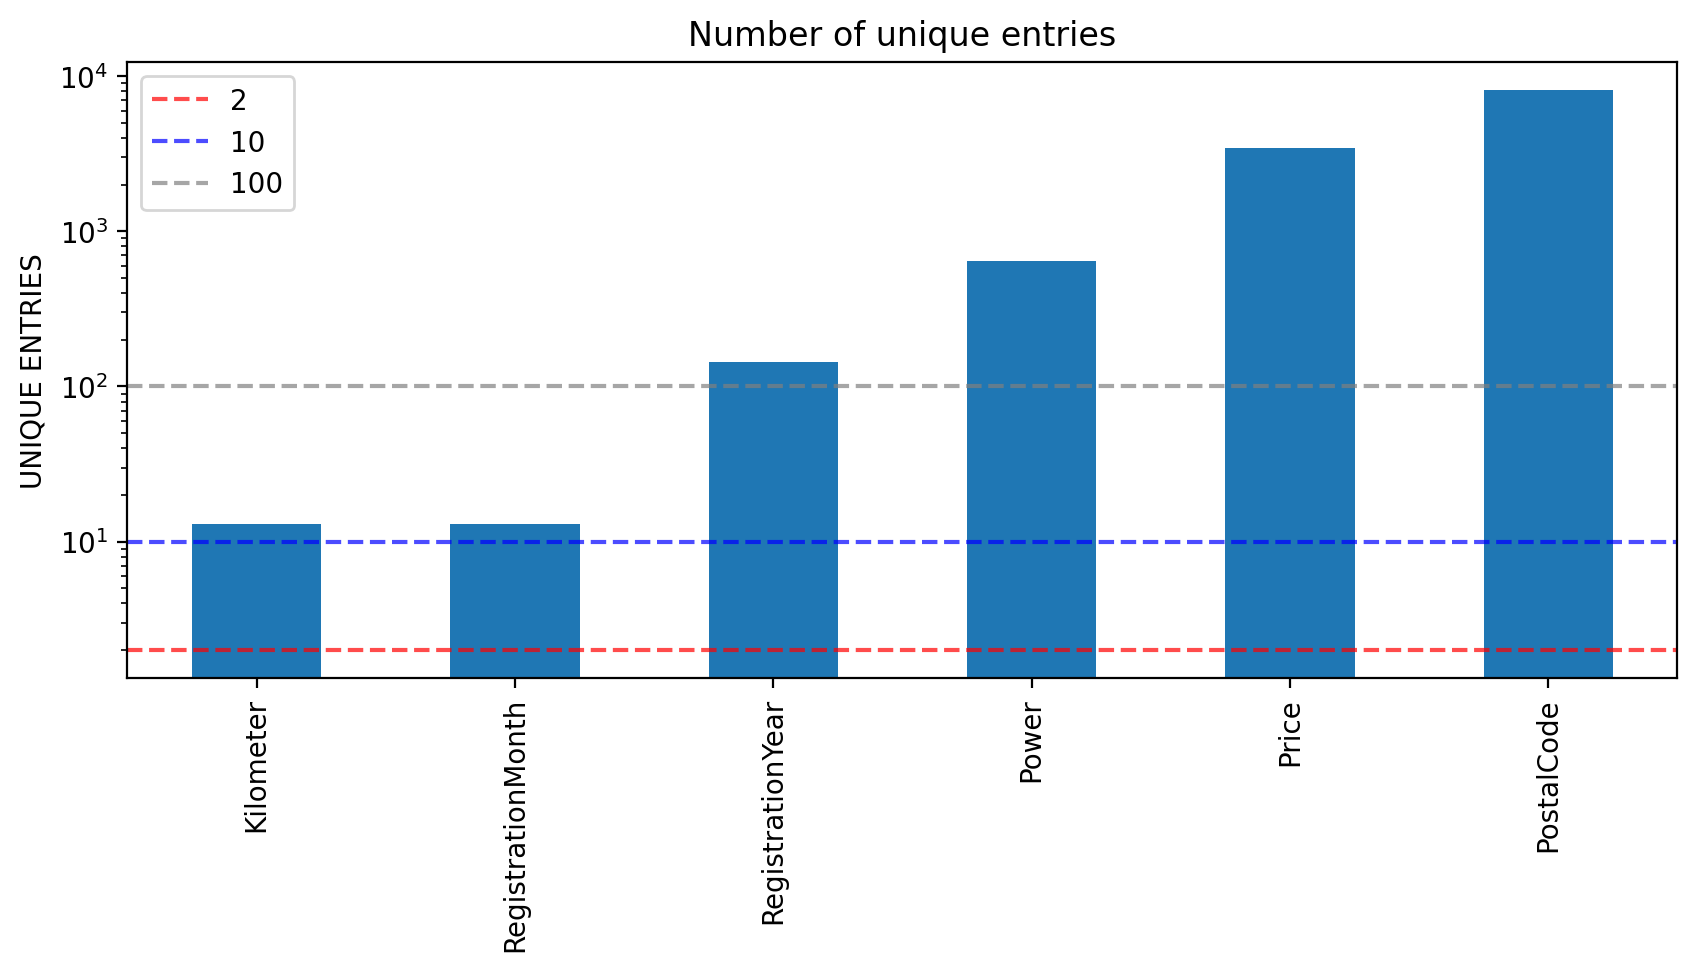

In [39]:
# For each numerical feature compute number of unique entries and sort them
unique_values = df[numerical_columns].nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(
    logy = True, figsize = (10, 4),
    title = "Number of unique entries"
);

# add horizontal lines for 2, 10 and 100 to easily recognize
# binary, ordinal and continious features
plt.axhline(2, color='red', alpha=0.7, linestyle='dashed')
plt.axhline(10, color='blue', alpha=0.7, linestyle='dashed')
plt.axhline(100, color='gray', alpha=0.7, linestyle='dashed')

plt.ylabel("Unique entries".upper())
plt.legend(['2', '10', '100'])
plt.show()

The `Kilometer` feature has a little more than 10 unique values, thus it is discrete.

`RegistrationMonth` is expected to have 13 values (12 months and zero).

Note that the number of unique values for the `RegistrationYear` feature is much larger than expected from the common sense because of its 1000–9999 values range. 

Also note that the engine capability is represented by approximately 600 unique values, and the cost is represented by 3 thousand unique values.

Postal codes vary the most.

##### Conclusions

We observed the dataset has numerical, categorical and time features.

`NumberOfPictures` contains only zeros and we can immediately exclude it from the further analysis.

Among other features, we expect to see implicit duplicates or/and missing values and other anomalies in the values.

#### Quality Investigation

Before focusing on the actual content stored in the features, let’s first take a look at the general quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries or recording errors.

##### Duplicates

In [40]:
duplicates_number = df.duplicated().sum()
print(f"{duplicates_number} are found in the dataset")

4293 are found in the dataset


The duplicates appeared after the `DateCrawled` was rounded to the nearest day. We observed some ads were loaded several times.

We do not need duplicates and drop them.

In [41]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(279202, 16)

##### Missing values

We observed both explicit and implicit missing values in the dataset. Let's calculate the share of missing valeus per feature. 

In [42]:
(df[datetime_columns + categorical_columns].isna().sum() /
 df.shape[0]).sort_values(ascending=True)

DateCrawled    0.000000
DateCreated    0.000000
LastSeen       0.000000
Brand          0.000000
Model          0.056300
Gearbox        0.056332
FuelType       0.093753
VehicleType    0.106529
NotRepaired    0.202345
dtype: float64

In [43]:
((df[numerical_columns] == 0).sum() / df.shape[0]).sort_values(ascending=True)

RegistrationYear     0.000000
Kilometer            0.000000
PostalCode           0.000000
Price                0.030533
RegistrationMonth    0.105845
Power                0.114082
dtype: float64

These features have missing values: `Model`, `Gearbox`, `FuelType`, `VehicleType`, `NotRepaired`, `Price`, `RegistrationMonth`, `Power`.

Missing values in target `Price` make these objects useless for model training and evaluation. Fortunately it's only 3% of such objects.

Both `Model` and `Gearbox` have about 5,5% of missing values. Then goes `FuelType`, `VehicleType`, `RegistrationMonth` and `Power` with 10% and the feature with a biggest share of missing values 20% `NotRepaired`.

Let's have a look at number of missing values per sample.

In [44]:
nan_columns = ['Price', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'RegistrationMonth', 'Power']

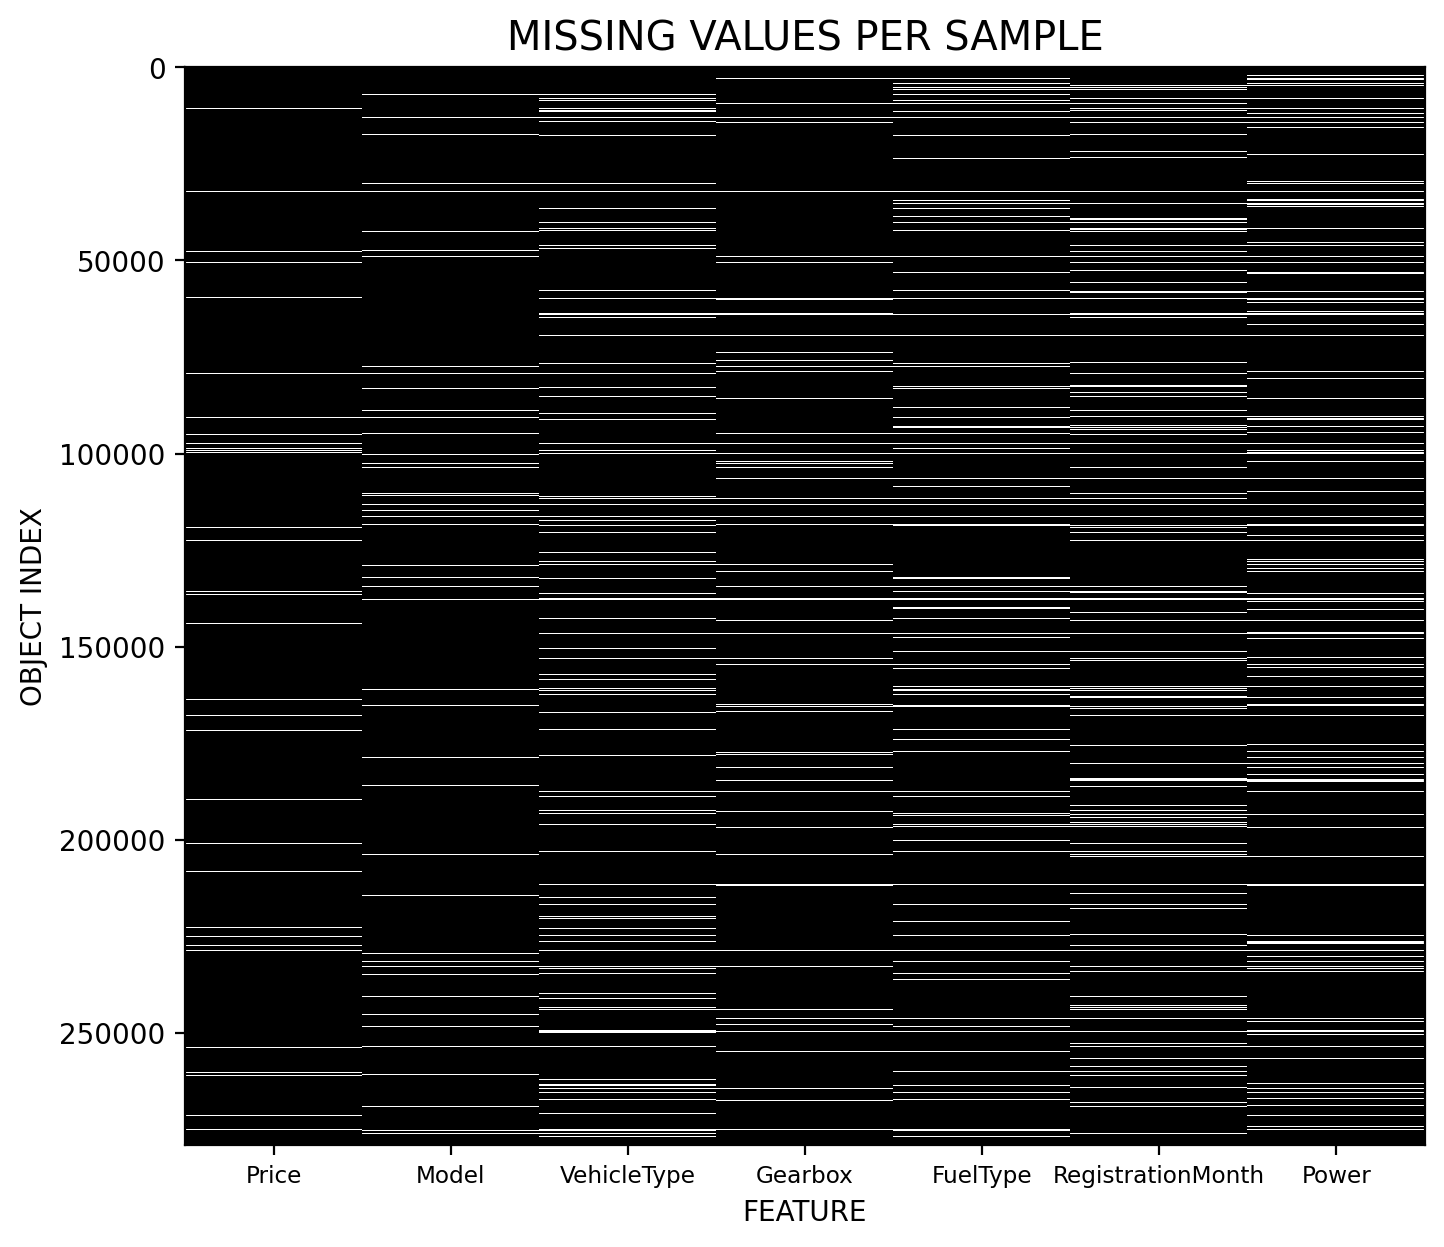

In [45]:
plt.figure(figsize=(8, 7))
plt.imshow((df[nan_columns].isna()) |
           (df[nan_columns] == 0),
           aspect='auto',
           interpolation='nearest',
           cmap='gray')
plt.xlabel("Feature".upper())
plt.xticks(ticks=range(len(nan_columns)),
           labels=nan_columns,
           fontsize='small')
plt.ylabel("Object index".upper())
plt.title('Missing values per sample'.upper(), fontsize='x-large')
plt.show()

We observe the missing values are distributed over the dataset more or less evenly, without obvious patterns.

Some objects have missing values in all observed features, they are represented by horizontal lines on the chart. That is, the dataset have objects for which only the car brand and mileage are known.

Some objects miss values just in one or couple of fueatures. Perhaps for such objects we will be able to fill in the mising values based on the values of other features.

Now we drop the objects with missing `Price` as useless for modeling and further analysis. 

In [46]:
df = df[df.Price > 0]
df.shape

(270677, 16)

##### Unwanted entries and recording errors

Another source of quality issues in a dataset can be due to unwanted entries or recording errors. It’s important to distinguish such samples from simple outliers. While outliers are data points that are unusual for a given feature distribution, unwanted entries or recording errors are samples that shouldn’t be there in the first place.

Let's take a global view on the dataset and see if we can identify some unusual patterns.

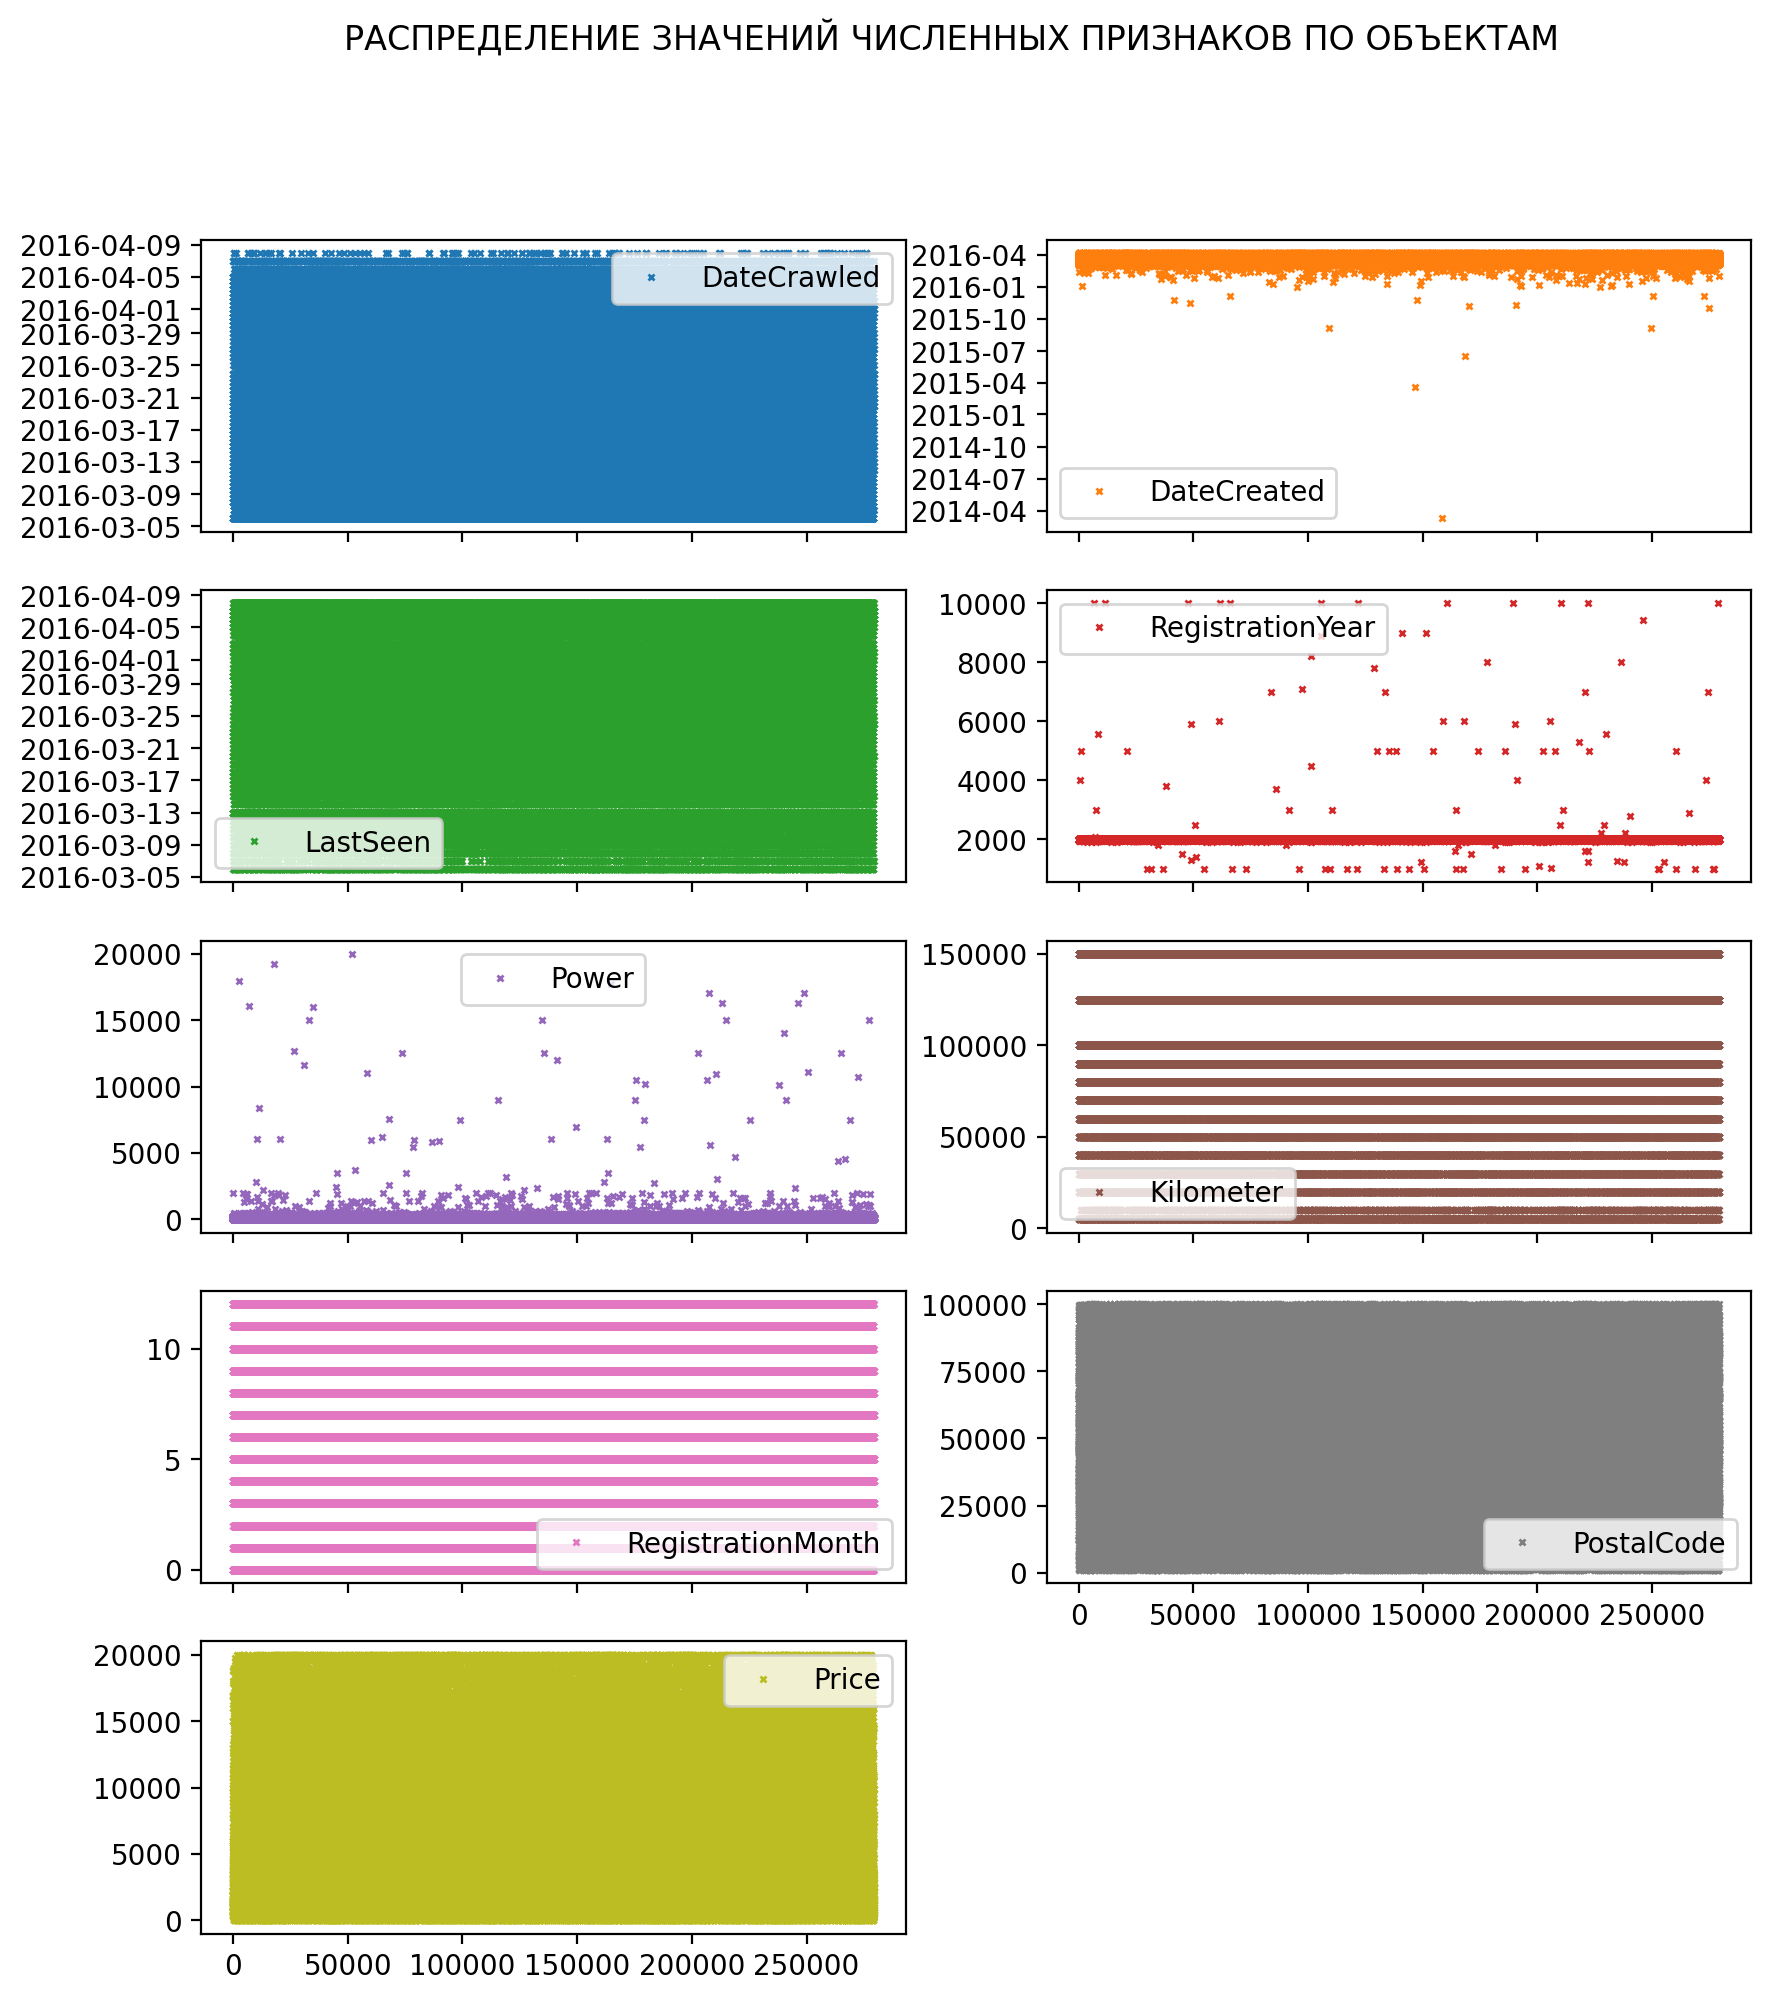

In [47]:
df[datetime_columns + numerical_columns].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 11), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
);

plt.show()

Each point in this figure is a sample (i.e. an object) in our dataset and each subplot represents a different feature. The y-axis shows the feature value, while the x-axis is the sample index. 

In an ideal case when data has no issues we will observe an even distribution of points over the chart area like we see for `RegistrationMonth` or `Price`.

We do not observe and patterns in the dataset. The feature values are randomly distributed over all objects.

We see rare non-realistic values for `RegistrationYear` and `Power`. They occur evenly, which indicates errors in the ads, and not in the data collection process. 

##### Conclusions

We found duplicates in the data and removed them.

We explored explicit and implicit missing values in features. We dropped objects with missing target values from further analysis. 

We did not find unwanted patterns in the dataset, which indicates the correctness of data collection. Noted rare unwanted entries in `RegistrationYear` and `Power` features. 

We will definehow to address remaining missing values and unwanted entries after EDA will be done.

#### Content Investigation

##### Dateteme features

The dataset has three functions with datetime type. Let's look at their meanings.

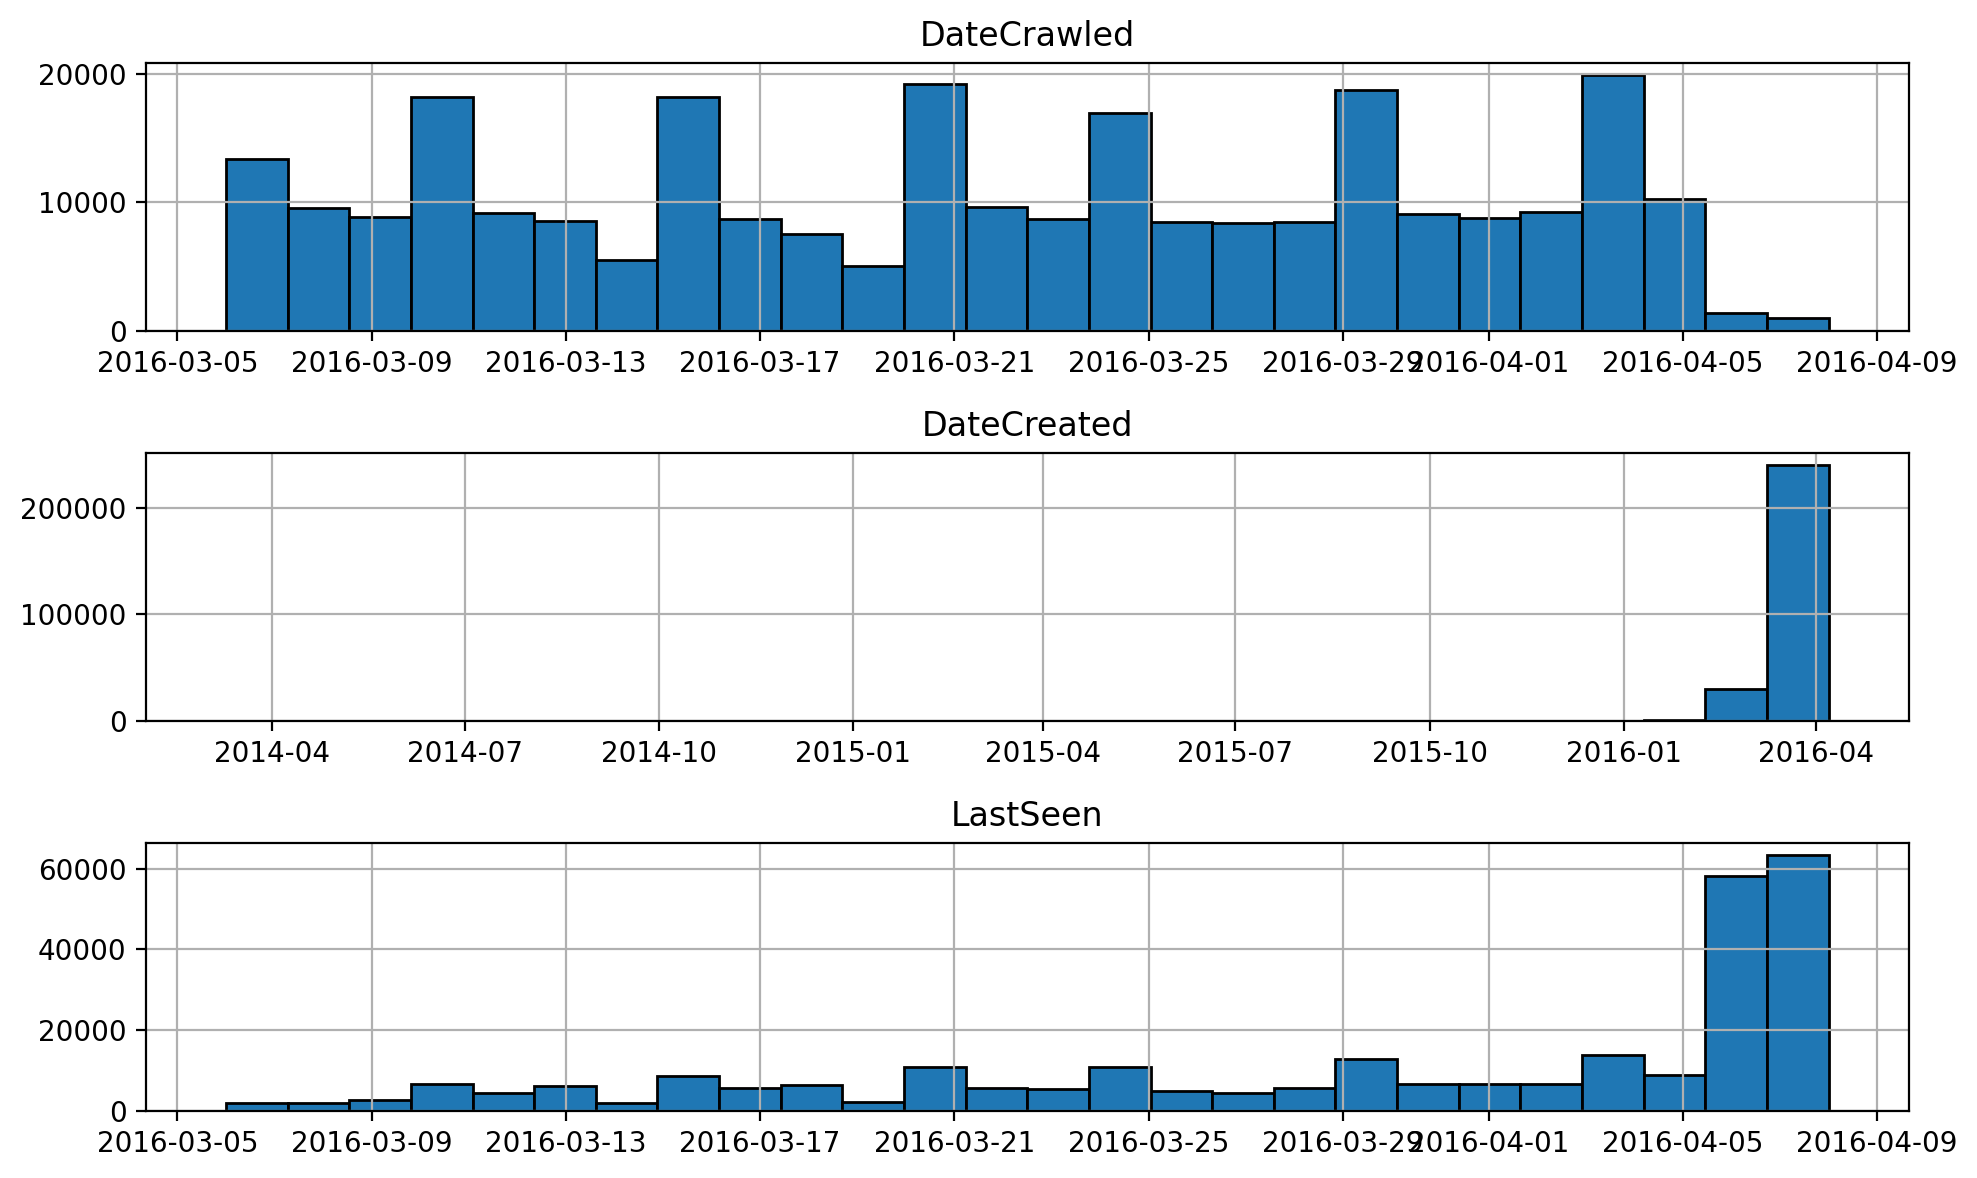

In [48]:
df[datetime_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 1),
                           edgecolor="black")
plt.tight_layout()
plt.show()

The crowling of ads began in March 2016 and ended in April 2016, lasting a little over a month.

Most of the collected ads were created in March-April 2016, which coincides with the dates of crowling. That is, most of the questionnaires were collected immediately after creation.

Most of the ads views also fall during this period, which seems like the service was launched in April 2016.

What if insted of analizing crowling dates we calculate and analize ads age as a number of days between creation and crowling? 

In [49]:
df['AnketaAge'] = (df.DateCrawled - df.DateCreated).astype('timedelta64[D]')

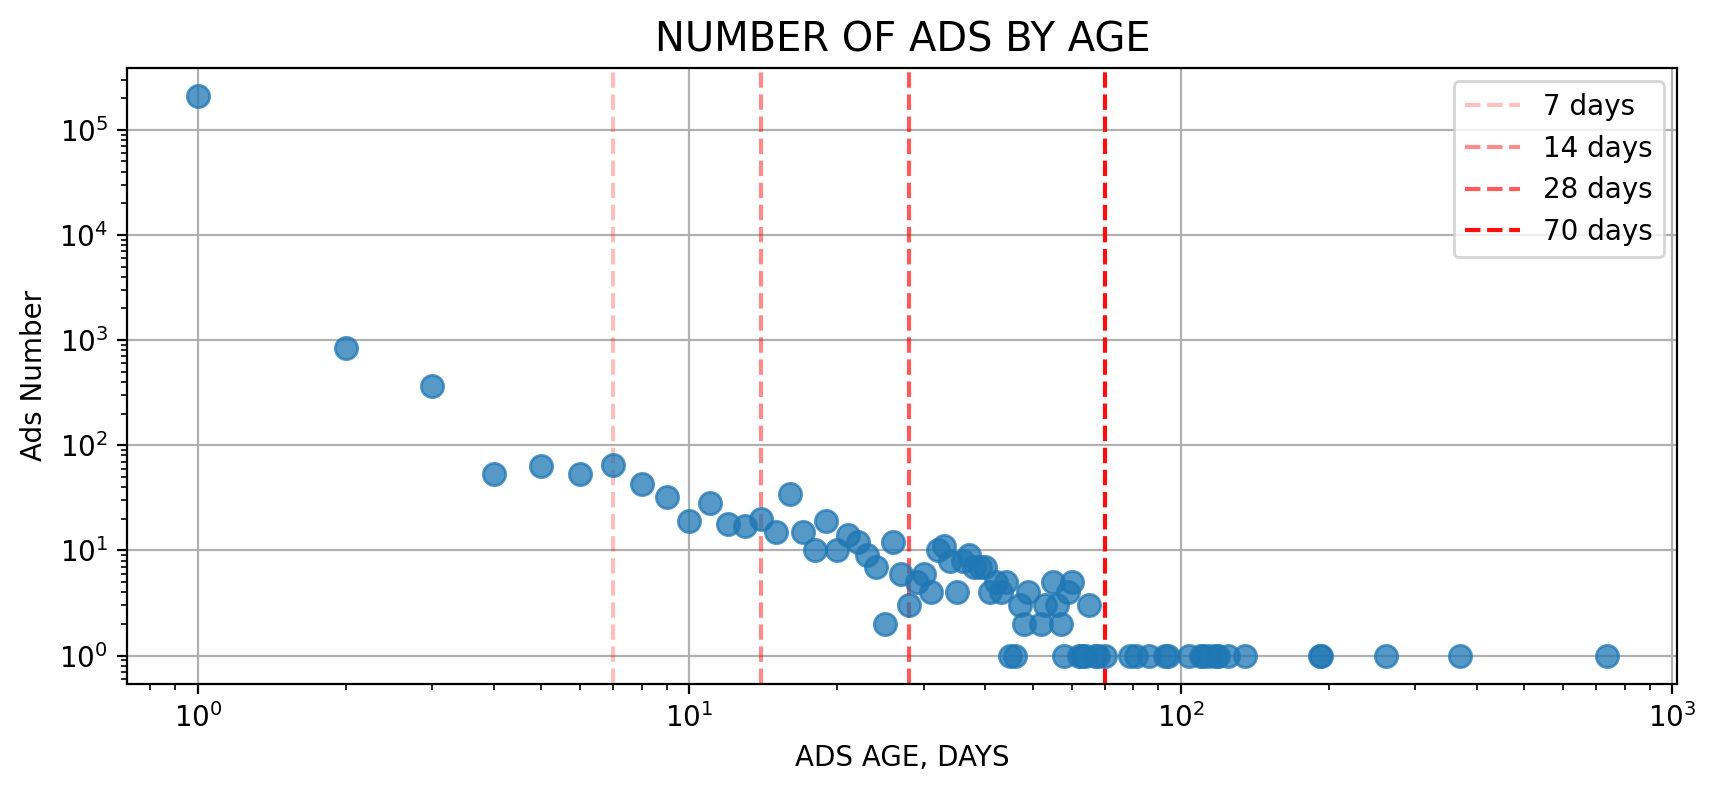

In [51]:
plt.axvline(7, c='r', alpha=.25, linestyle='dashed')
plt.axvline(14, c='r', alpha=.45, linestyle='dashed')
plt.axvline(28, c='r', alpha=.65, linestyle='dashed')
plt.axvline(70, c='r', alpha=.95, linestyle='dashed')

df.AnketaAge.value_counts(sort=False).sort_index().plot(lw=0,
                                                        marker='.',
                                                        markersize=16,
                                                        alpha=.75,
                                                        logy=True,
                                                        logx=True,
                                                        grid=True, 
                                                        figsize=(10, 4))

plt.title('Number of ads by age'.upper(), fontsize='x-large')
plt.xlabel('Ads age, days'.upper())
plt.ylabel('Ads Number')
plt.legend(['7 days', '14 days', '28 days', '70 days'])
plt.show()

Most ads in the dataset are one day old, then goes hundreds of two and three day old ads. Further up to 70 days, we see a rapidly decreasing number of ads with increasing age. Finaly we see a tail of ads older then 70 days.

Let's have a look at a most old ads.

In [52]:
df[df.AnketaAge > 365].T

,146707,158311
DateCrawled,2016-03-24 00:00:00,2016-03-16 00:00:00
VehicleType,bus,NaN
RegistrationYear,1995,2005
Gearbox,auto,NaN
Power,200,0
Model,other,147
Kilometer,150000,125000
RegistrationMonth,0,0
FuelType,petrol,petrol
Brand,chevrolet,alfa_romeo


It looks quite normal.

The `LastSeen` feature has nothing to do with the analyzed objects, thus we will skip it further.

The `DateCreated` feature let us calculate car age in the next step.

##### Numerical features distribution

Histogram and boxplot charts help us to analize numerical features.

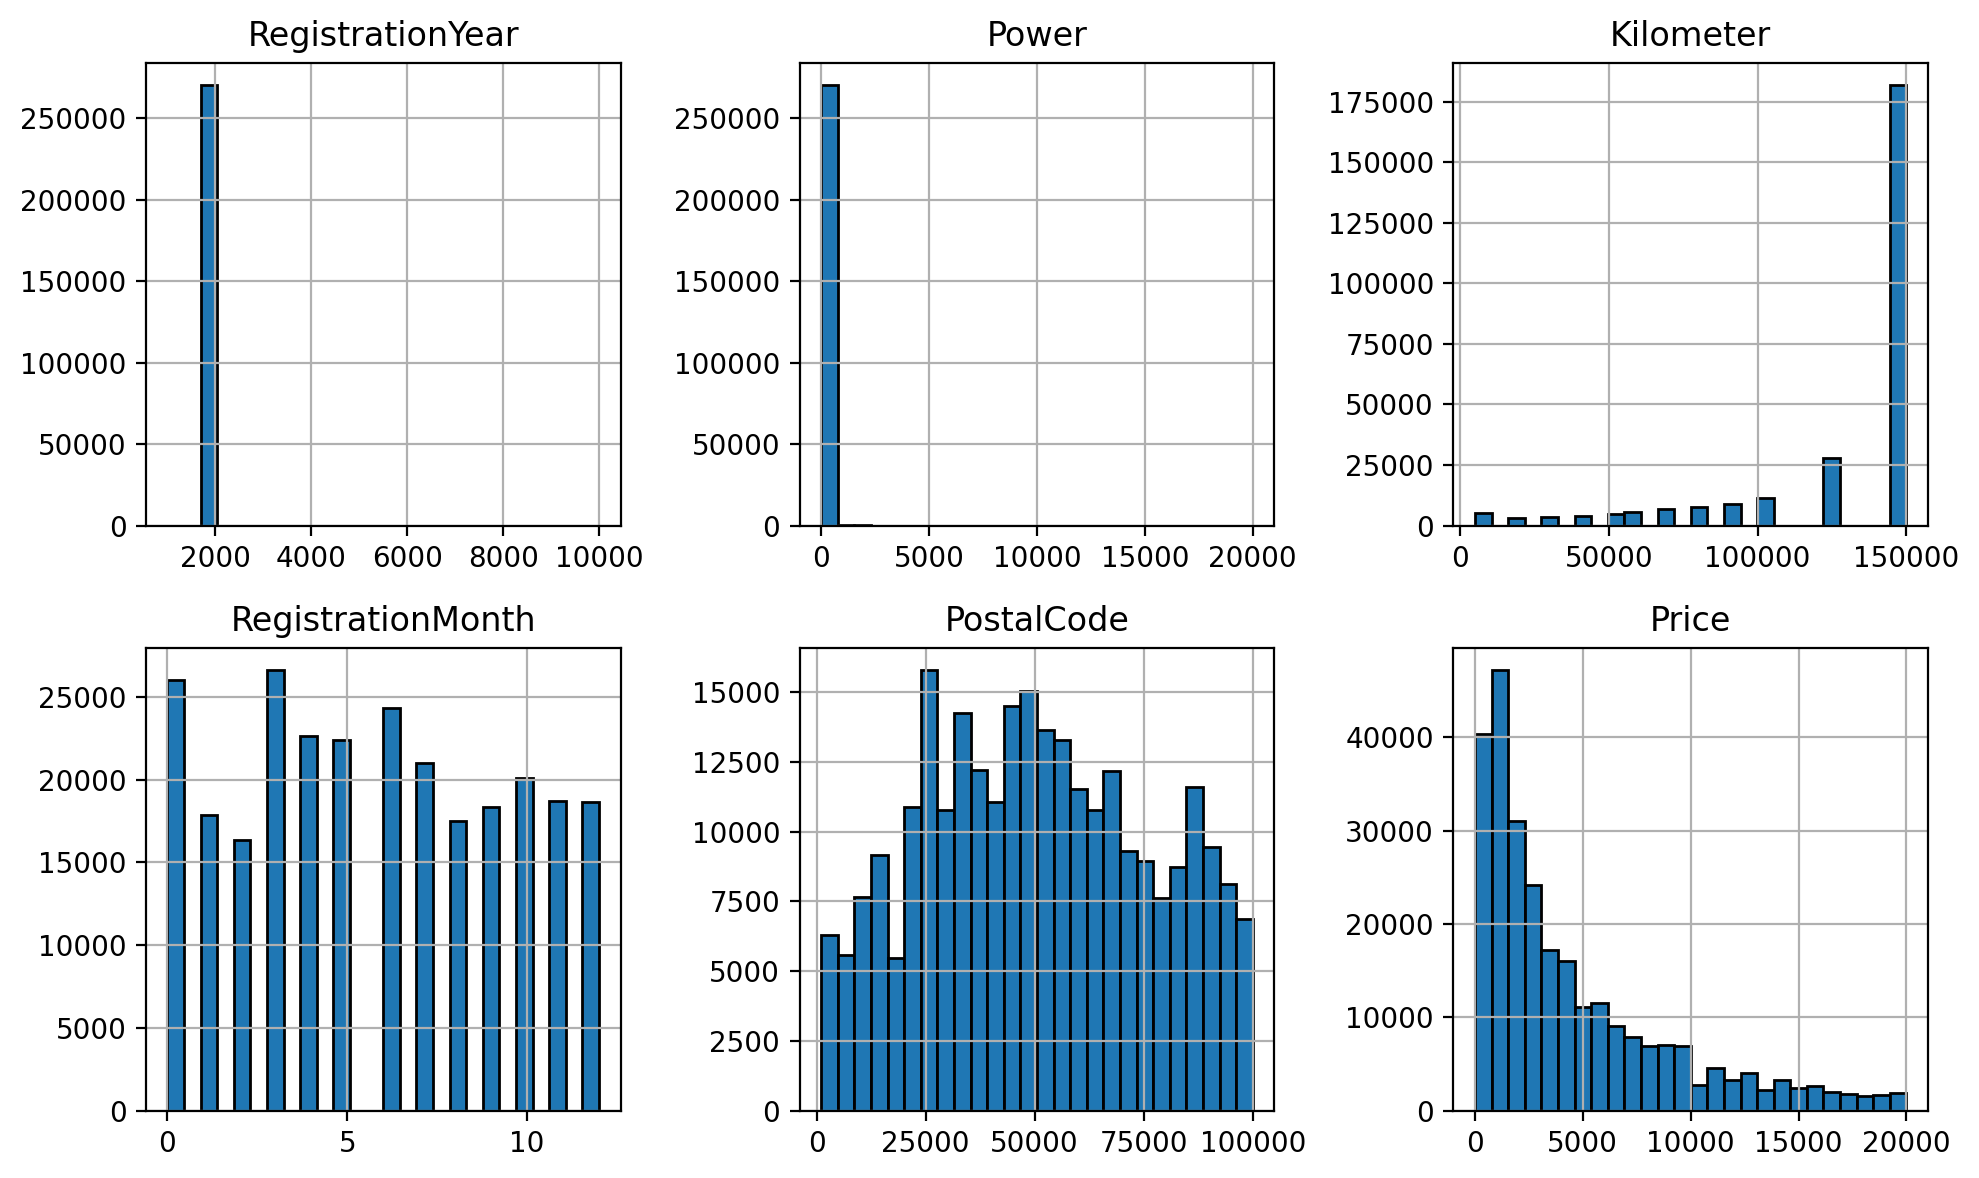

In [53]:
df[numerical_columns].hist(bins=26,
                           figsize=(10, 6),
                           layout=(-1, 3),
                           edgecolor="black")
plt.tight_layout()
plt.show()

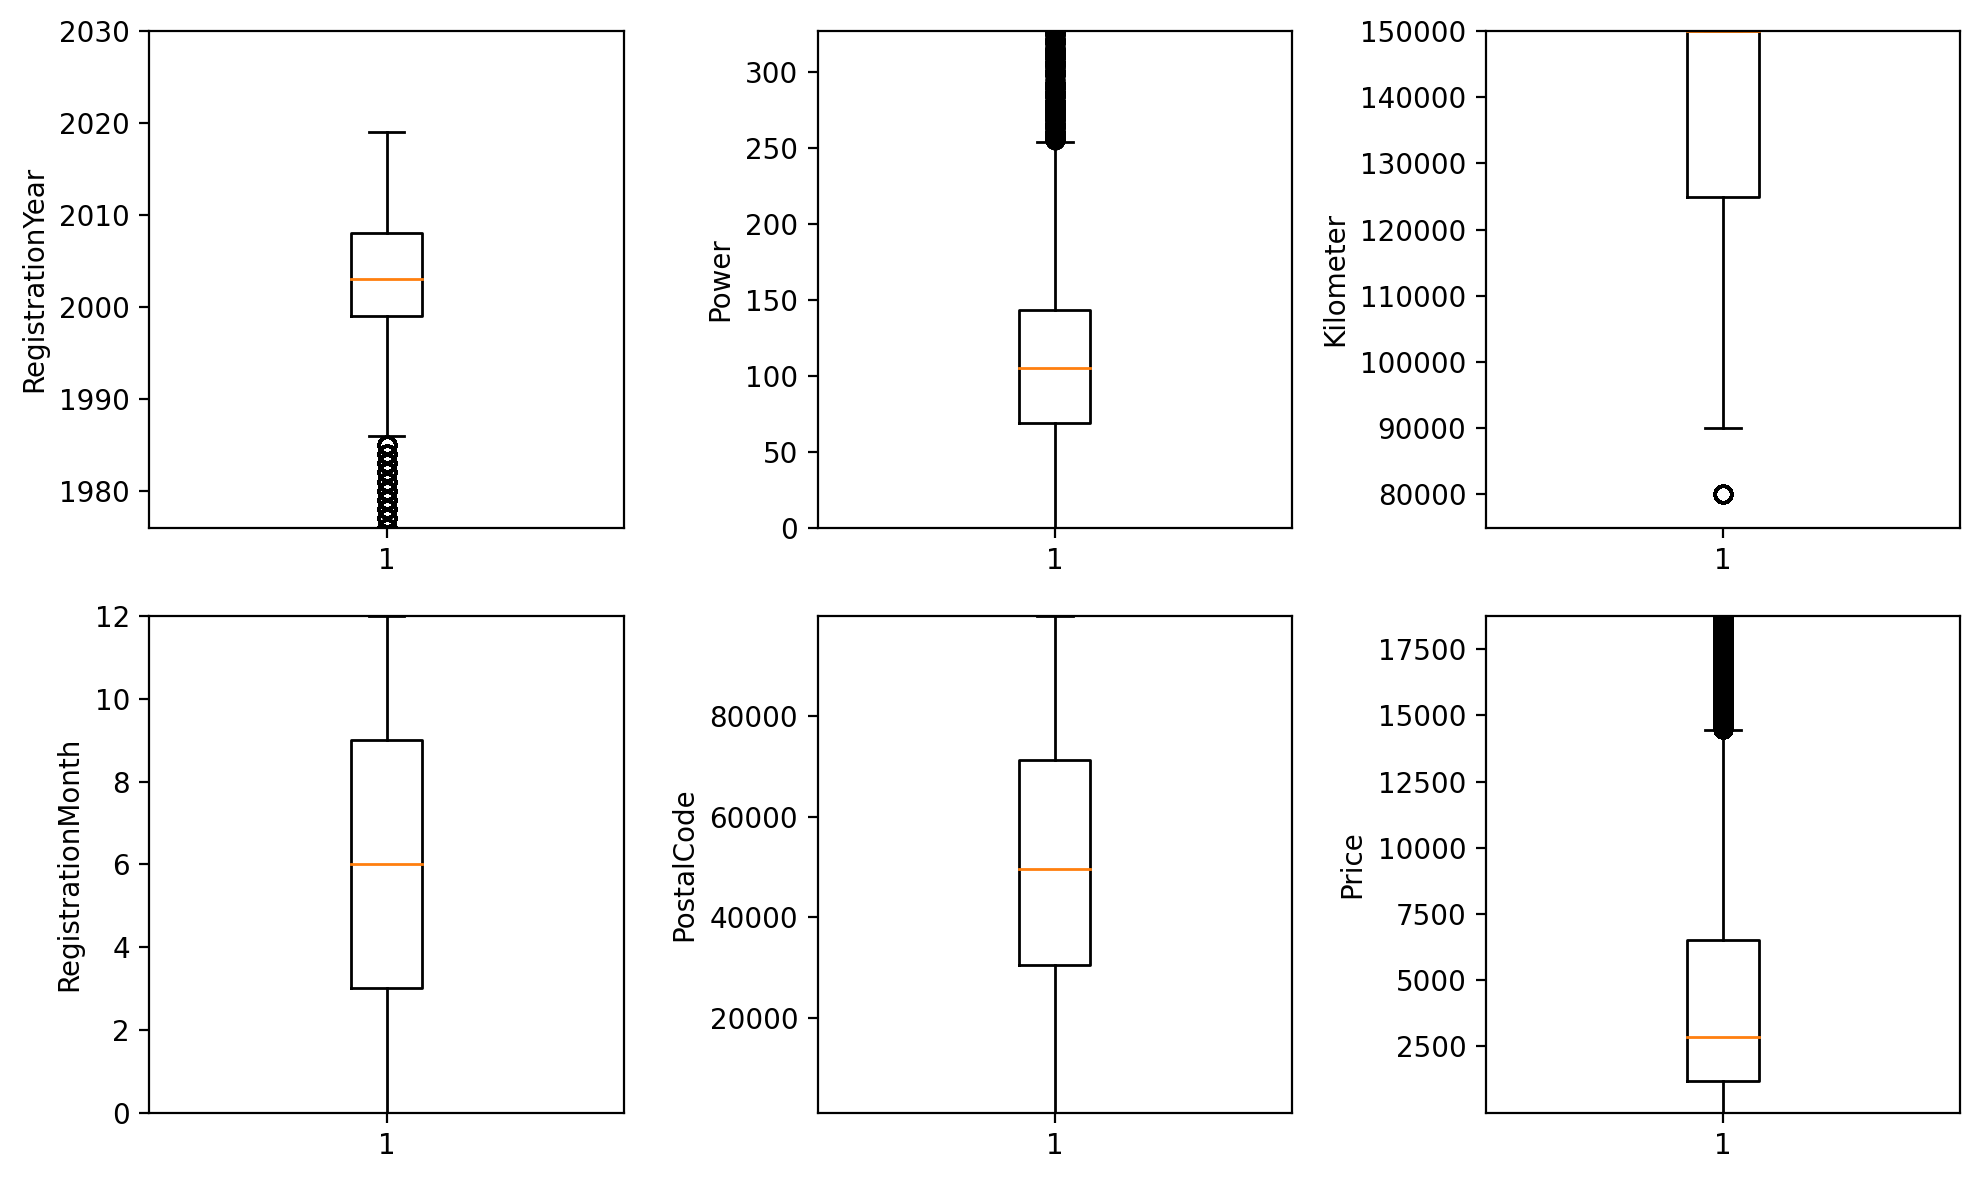

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

def draw_boxplot(ax, x, column_name, ylabel):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    median = x.median()
    data_range = (
        max(x.min(), median-3*iqr),
        min(x.max(), median+3*iqr)
    )
    ax.boxplot(x=x)
    ax.set_ylim(data_range)
    ax.set(ylabel=column)
    
for column, ax in zip(numerical_columns, axes.ravel()):
    draw_boxplot(ax, df[column], column, 'label')
plt.tight_layout()
plt.show()

The `Price` distribution looks like a lognormal distribution. For it a long tail of values is normal. We do not observe anomalies here.

The distribution of the mileage is also similar to lognormal multiplied by -1 and shifted by 150000. We do not observe anomalies here.

We also see no anomalies in the distribution of `RegistraionMonth` and `PostalCode` values.

`RegistrationYear` and `Power` have unwated entries as we already knew. Let's analyze these features in depth. 

**CAR REGISTRATION YEAR**

Let's add a new feature `CarAge` instead of two `RegistrationYear` and `RegistrationMonth`: 

$ \mathit{CarAge} = (\mathit{DateCreated.year} \times 12 + \mathit{DateCreated.month}) - \
(\mathit{RegistrationYear} \times 12 + \mathit{RegistrationMonth}) \div 12$

In this case, we will ignore the error of 1 month, which will occur for objects with `RegistrationMonth` equal to zero.

In [55]:
df['CarAge'] = round(
    (df.DateCreated.dt.year * 12 + df.DateCreated.dt.month -
     df.RegistrationYear * 12 - df.RegistrationMonth) / 12).astype('int')
df[['RegistrationYear', 'RegistrationMonth', 'DateCreated', 'CarAge']].head()

,RegistrationYear,RegistrationMonth,DateCreated,CarAge
0,2010,12,2016-03-14,5
1,2011,6,2016-03-18,5
2,2004,10,2016-03-28,11
3,2004,4,2016-03-28,12
4,2000,4,2016-03-30,16


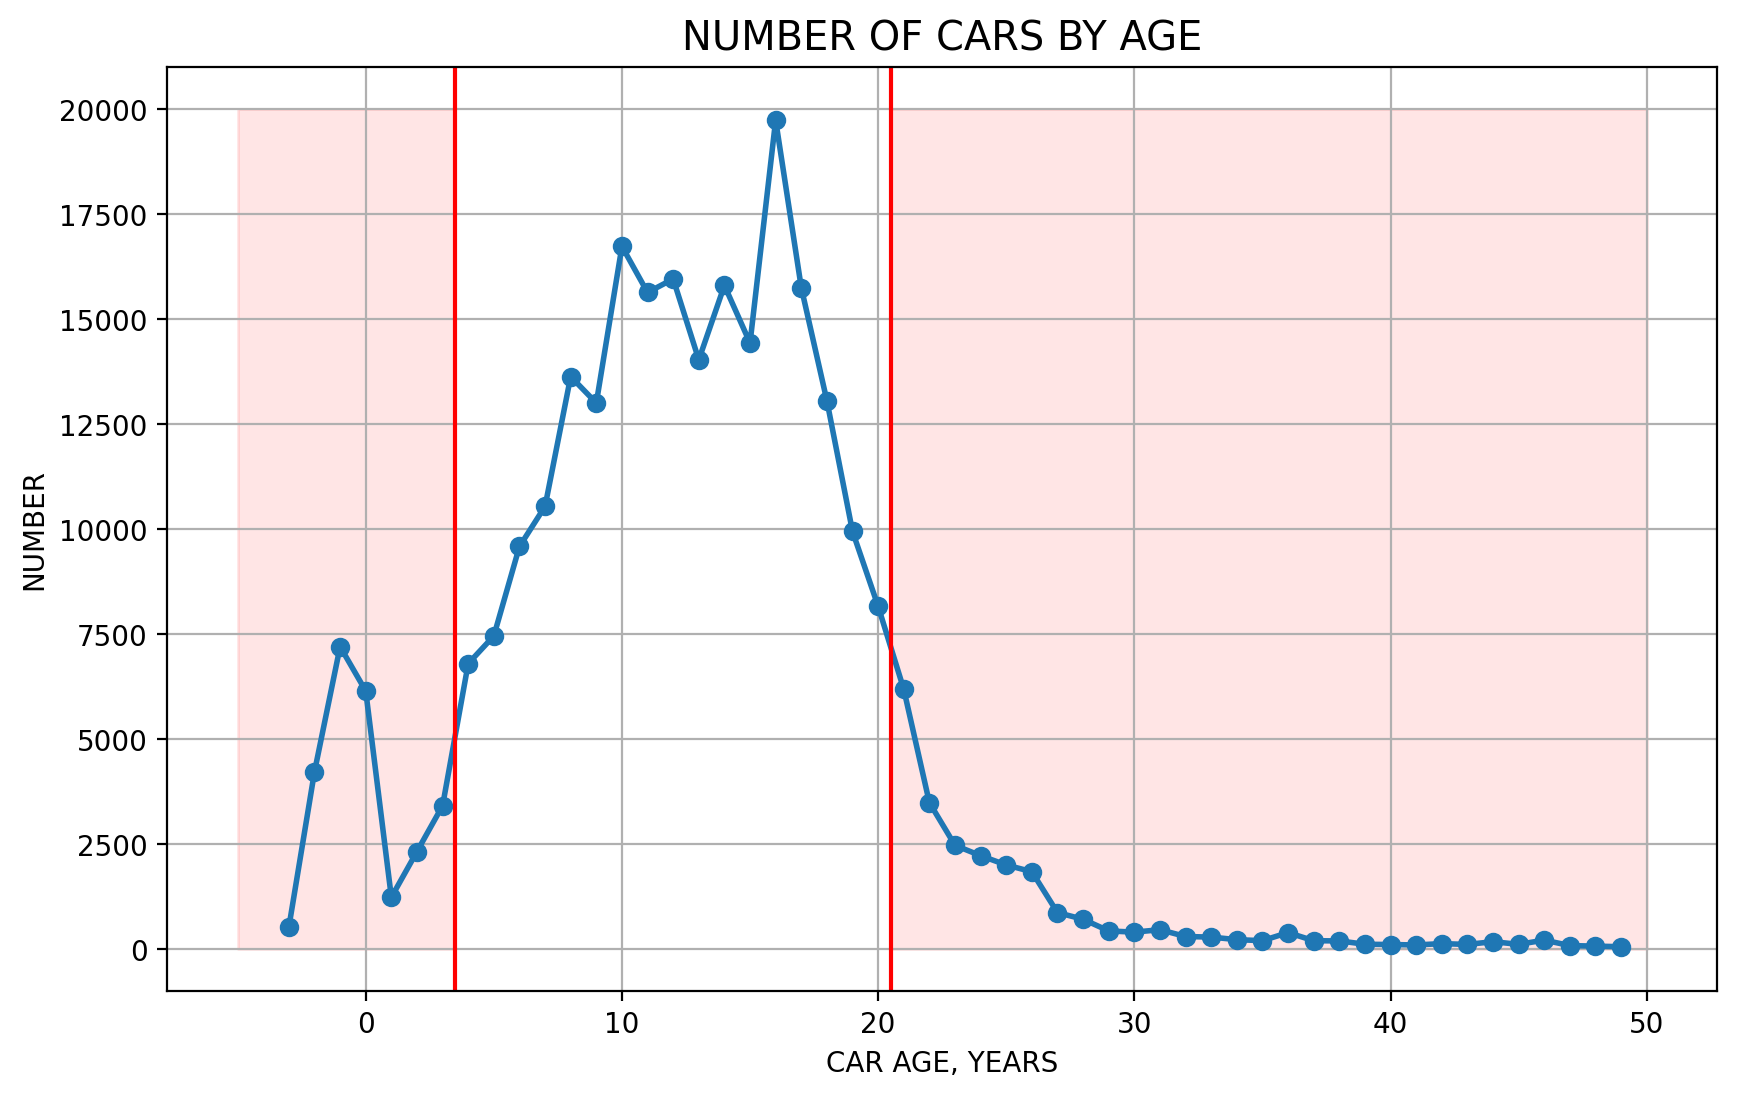

In [57]:
df.loc[(df.CarAge > -5) & (df.CarAge < 50),
       ['CarAge', 'Price']].groupby(['CarAge']).count().plot(lw=2,
                                                             marker='o',
                                                             grid=True,
                                                             legend=None, 
                                                             figsize=(10, 6))
plt.axvline(3.5, c='r')
plt.axvline(20.5, c='r')
plt.fill_between([-5, 3.5], 20000, color='r', alpha=.1)
plt.fill_between([20.5, 50], 20000, color='r', alpha=.1)
plt.title('Number of cars by age'.upper(), fontsize='x-large')
plt.ylabel('Number'.upper())
plt.xlabel('Car age, years'.upper())
plt.show()

Most ads are between 4 and 20 years old. About 15K of cars in the dataset have negative age. Also we see a long tail of very old cars.

Let's see how the price changes depending on the age of the car. 

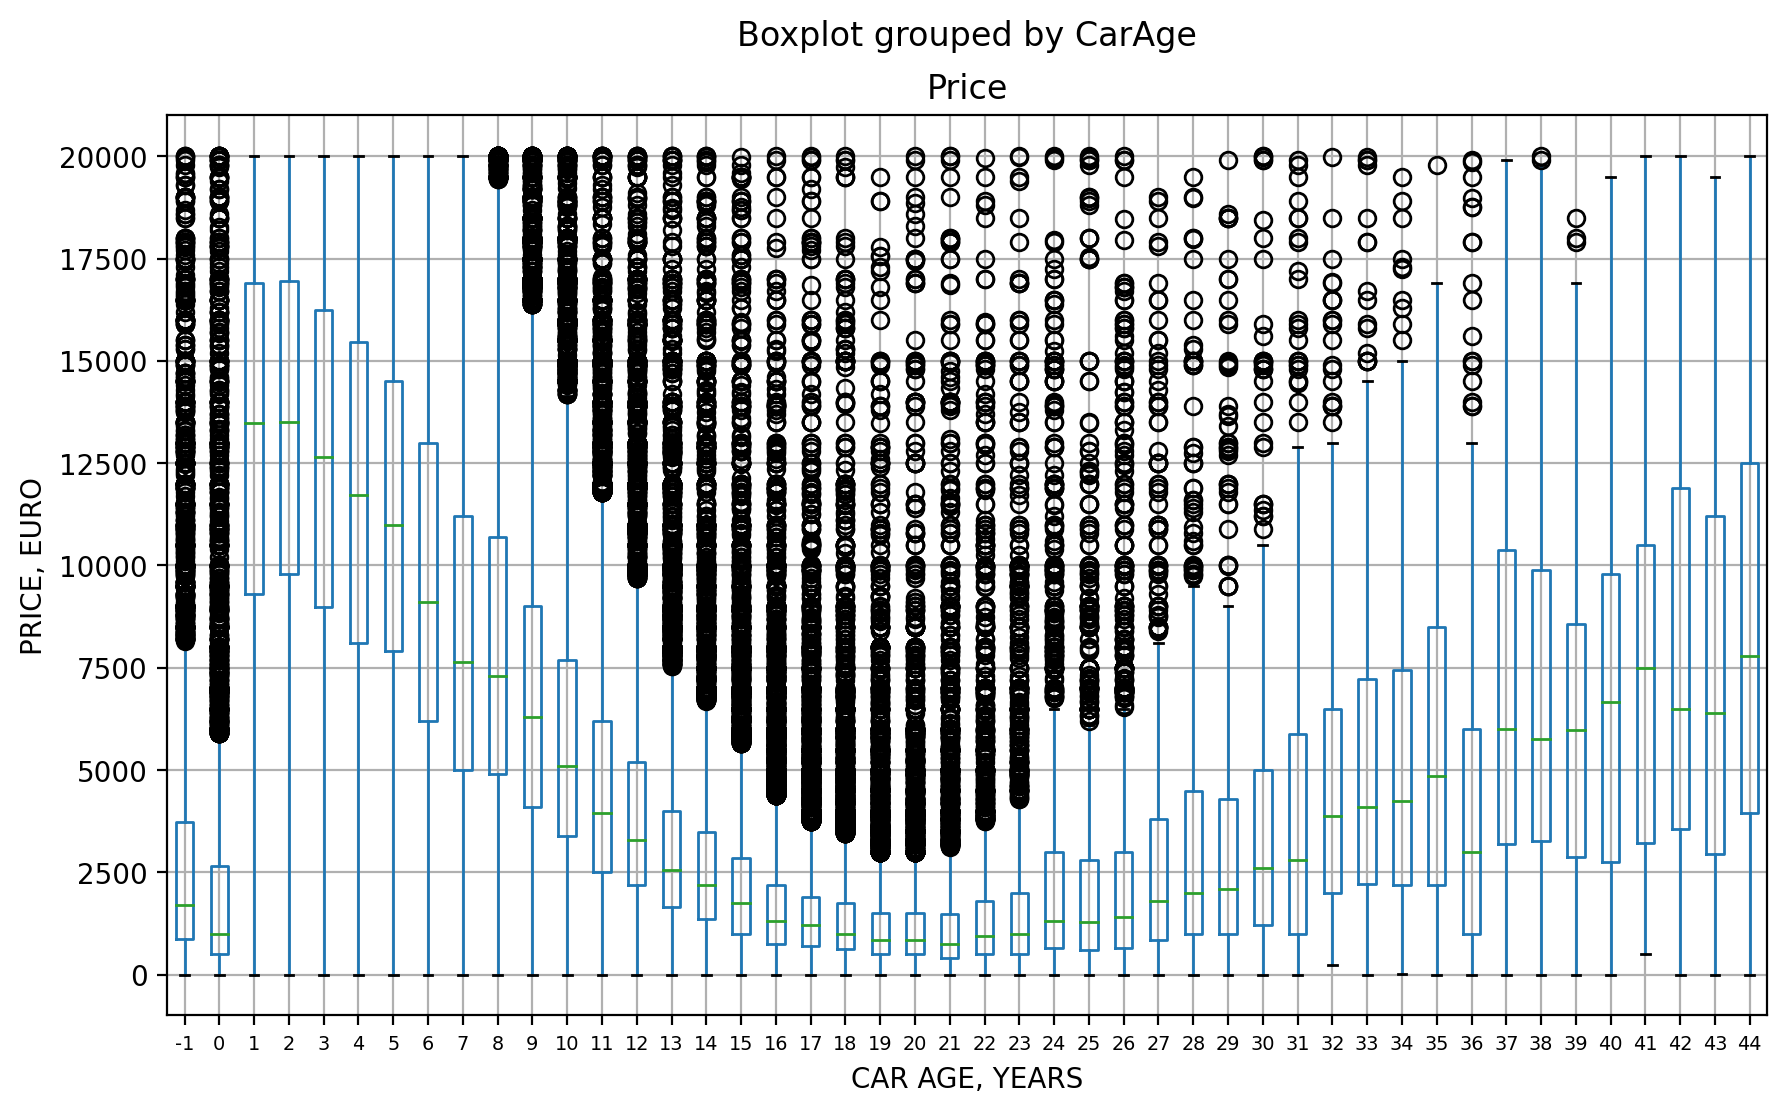

In [58]:
df.loc[(df.CarAge > -2) & (df.CarAge < 45),
       ['CarAge', 'Price']].boxplot(column='Price',
                                    by='CarAge',
                                    figsize=(10, 6))
plt.xlabel('Car age, years'.upper())
plt.xticks(fontsize='x-small')
plt.ylabel('Price, Euro'.upper())
plt.show()

Cars aged 0 and -1 year have much lower price than for ages 1 or 2 years. So we can't say that 0 is a new car.

The interquartile distance decreases with increasing age of the car up to 20 years. That indicates a decrease in price dispersion. The smallest interquartile distance is for the age of 19–21 years. Then the price spread grows again.

According to [American Collectors Community](https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/), cars over 20 years old are classified as Classic Cars, and over 45 years old are classified as Antique Cars.

Let us limit the scope of the developed models to the car age from 4 to 20 years inclusive. Up to 4 years, we have few ads and a wide range of prices. Cars over 20 years old are in a specific category. For these cars, a different model needs to be developed if the business needs to predict the cost of classic and antique cars.

**ENGINE POWER**

The dataset has error entries for `Power` like 1 hp or 20000 hp. Given that

- engine power of modern top commercial cars is up to 500hp ([source hotcars.com](https://www.hotcars.com/most-powerful-engines-ever-fitted-production-cars/)),
- the service is focused on the mass segment, so we do not consider sports cars with a power of up to 1700 hp,
- on the boxplot, we see that values greater than 250 hp are already in the outliers zone,

Let us limit the scope of our model with power from 50 to 250 hp.

Since engine power is an important parameter of a car, we are going to fill in the missing values with average values for the brand and model of a car. Those ads where the average value cannot be calculated will be deleted.

**PRICE**

Let's see how the price grows in our dataset across objects sorted by it. 

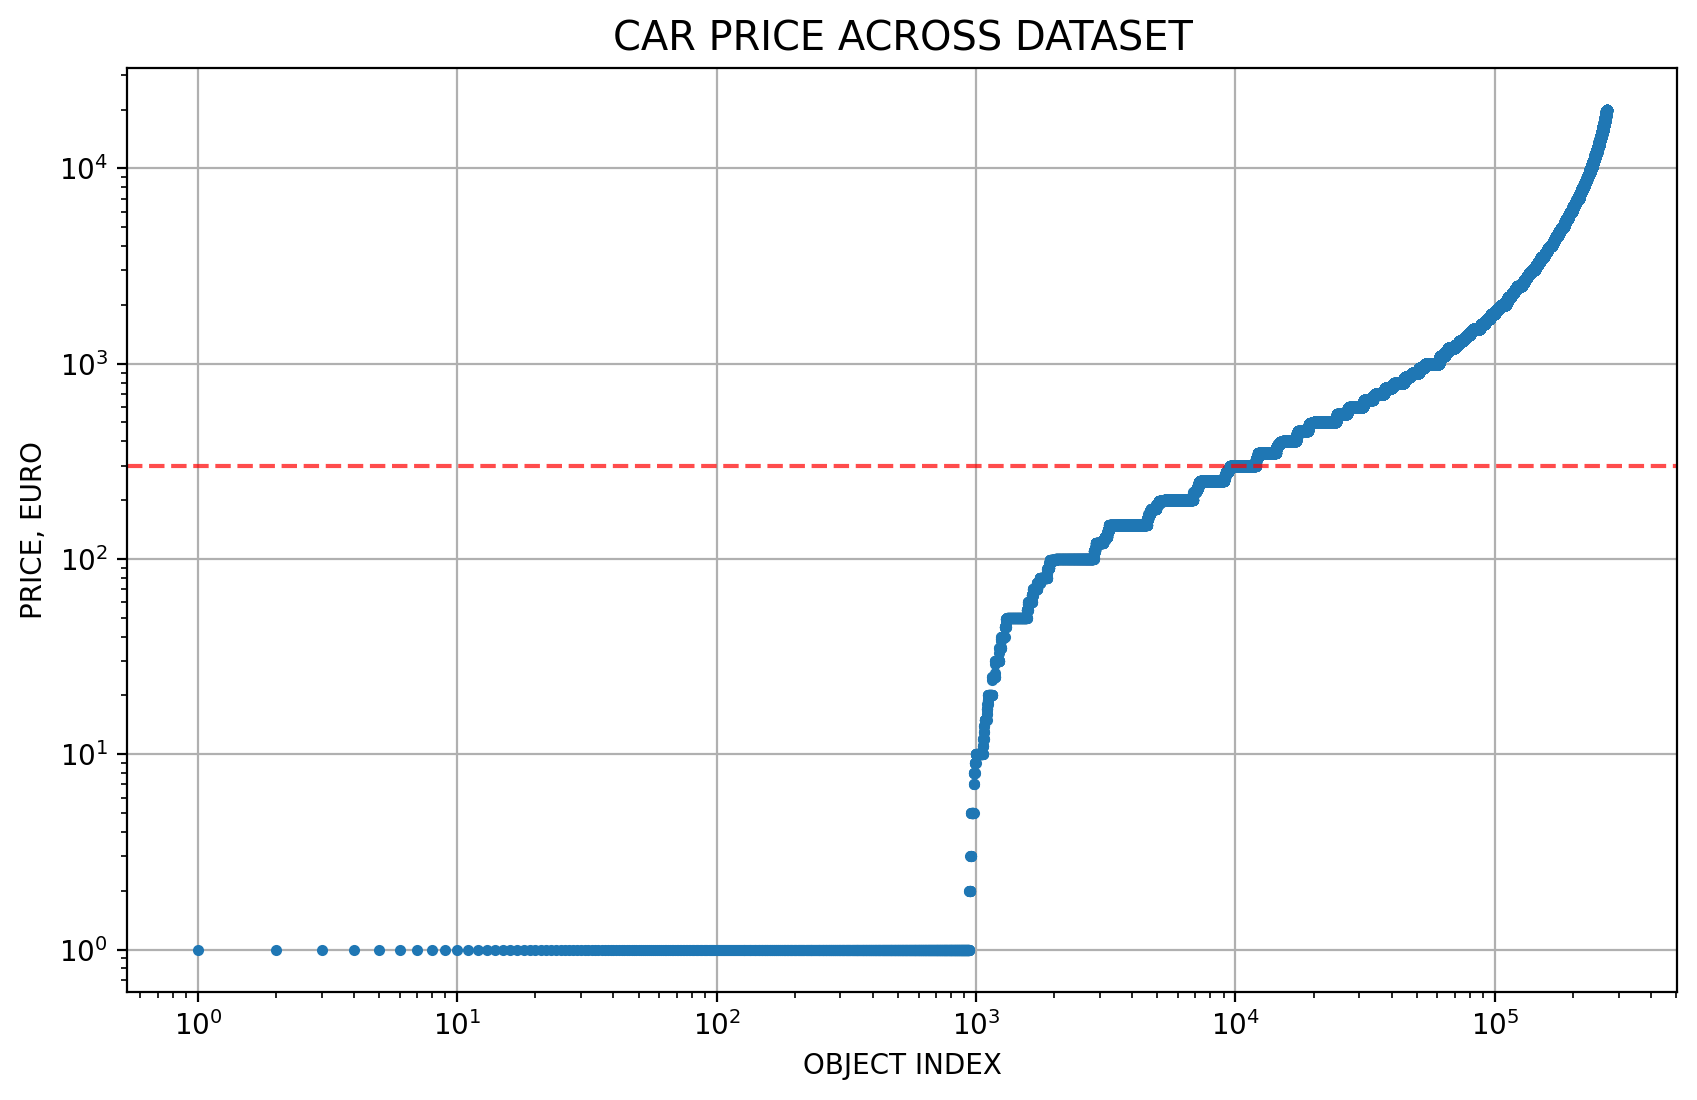

In [59]:
fig = plt.figure(figsize=(10, 6))
plt.plot(range(df.shape[0]),
         df.Price.sort_values(),
         marker='o',
         lw=0,
         ms=3)
plt.axhline(300, color='red', alpha=0.7, linestyle='dashed')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.title('Car price across dataset'.upper(), fontsize='x-large')
plt.ylabel('Price, Euro'.upper())
plt.xlabel('Object index'.upper())
plt.show()

There are 1000 objects in the dataset with a price of 1 euro and another 1000 with a price of less than 100 euros. 10,000 ads have a value of less than 300 euros. It looks very strange given that the average [price for a 10-year-old car](https://www.statista.com/statistics/589613/average-prices-for-used-cars-germany/#statisticContainer) in Germany is about 7,000 euros .

However, on the website [autoscout24.de](https://www.autoscout24.com/lst?sort=price&desc=0&atype=C&ustate=N%2CU&powertype=kw&priceto=500&search_id=vslwgpr1pq) there are indeed 1000 ads with a price of 1 euro. Bit this ads rather looks like for parts, but not cars.

Note that on the website [autoscout24.de](https://www.autoscout24.de/) we also see a large number of ads with old cars and a price of several hundred euros, which in reality are ads for spare parts: body parts, engines etc.

In such advertisements with "spare parts" on [autoscout24.de](https://www.autoscout24.de/) the features are not filled in, the gaps in which we also observed in our dataset: body type, gearbox type. Thus, gaps may indicate that the ad describes a part, but not a car.

Thus we limit the scope of our model to a minimum price of 300 euros.

##### Non-numerical features

Now we take a general look at how many unique values each of the non-numerical features contain, and how often their most frequent category is represented.

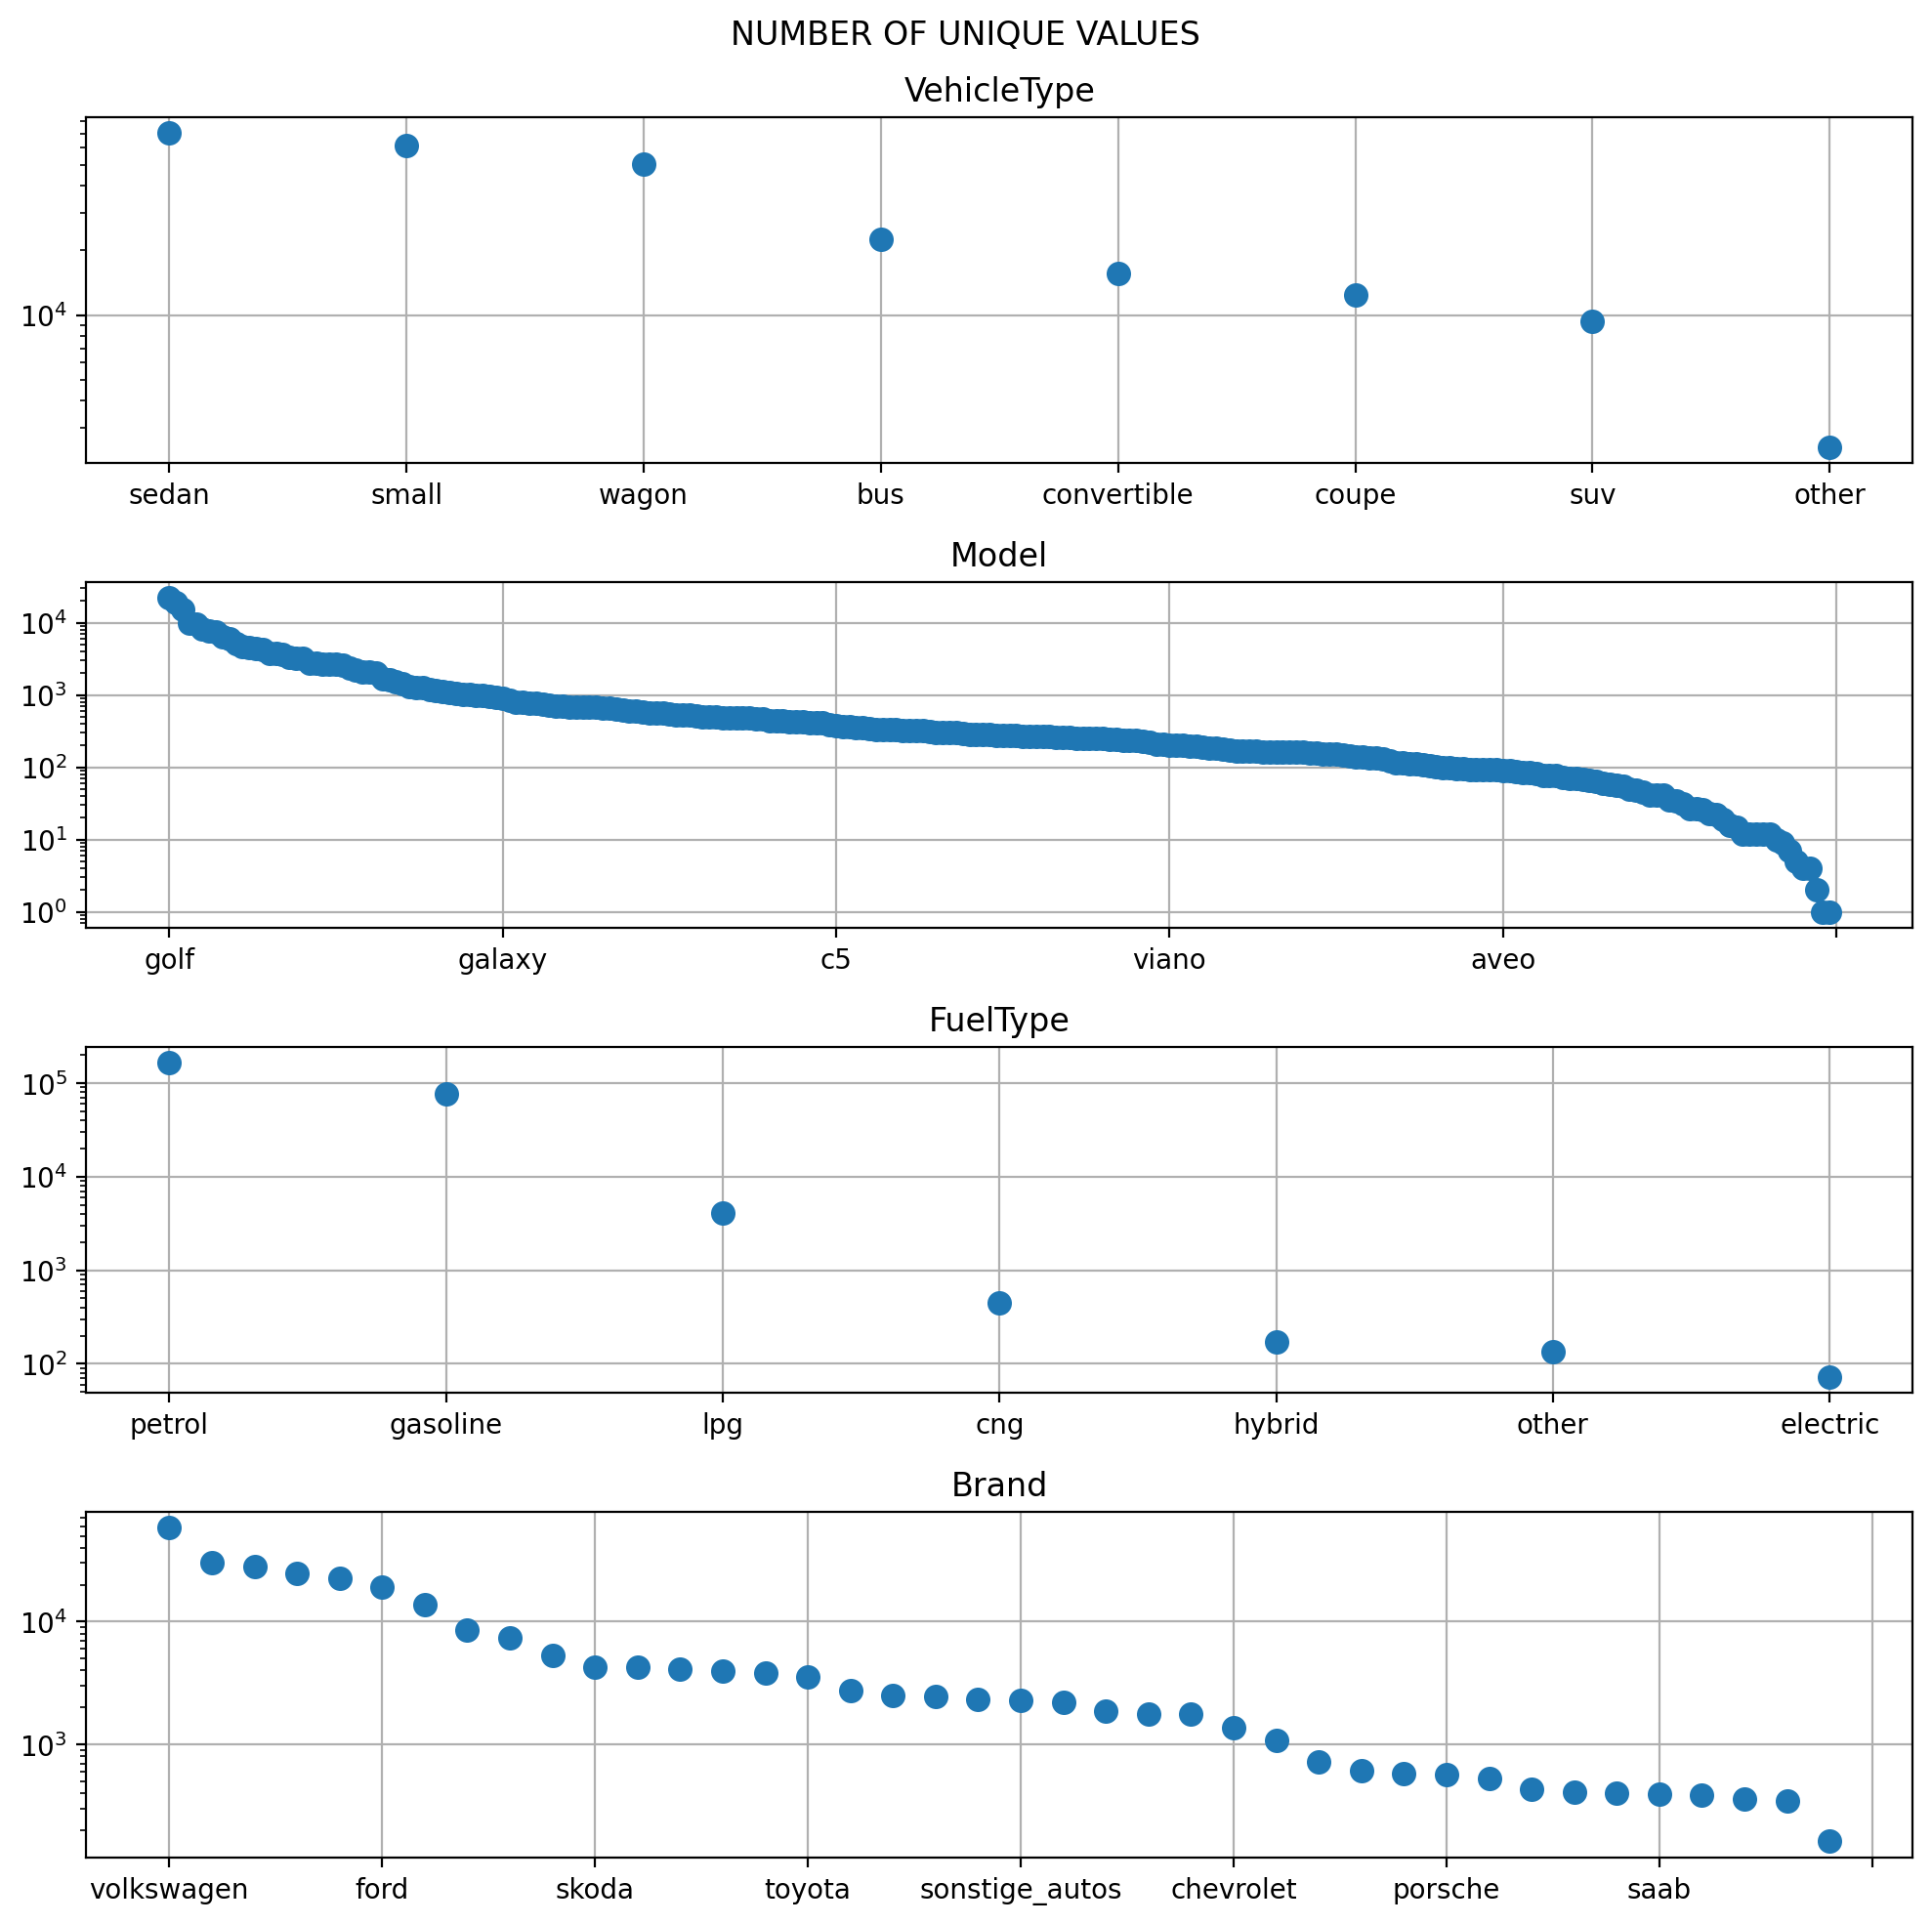

In [60]:
columns = [_ for _ in categorical_columns if _ not in ['Gearbox', 'NotRepaired']]

fig, axes = plt.subplots(ncols=1,
                         nrows=len(columns),
                         figsize=(10, 10))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df[col].value_counts().plot(
        logy=True,
        title=col,
        lw=0,
        marker='.',
        ax=ax,
        markersize=16,
        grid=True)

plt.suptitle("Number of unique values".upper())
plt.tight_layout()
plt.show()

**VEHICLE TYPE**

The values look good. The smallest number of objects has the value `other`.

Since the body type is an important characteristic of the car and is not uniquely determined by the model, missing values of this feature are critical for model training. Let's assume that the omission of the value indicates that the ad does not apply to the car, but describes the spare part.

Thus we define `VehicleType` as a required feature for the model. 

**MODEL**

The values look good. Note the small number of models on the rightmost side that have less than 10 listings.

Let's check the values for implicit duplicates.

In [61]:
df.Model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

We do not see implicit duplicates in the values. The value format is the same for all models.

The car model is critical to determining its price as well as vehicle type. Thus let's manage missing model values the same way as missing vehical typ. We assume the ads without vehicale type or model specified as ads for a spare part but a car. Such ads shall be droped from dataset. 

The `Model` is required for the model. 

**FUEL TYPE**

The two most common fuel type are petrol and gasoline. They are [the same](https://en.wikipedia.org/wiki/Gasoline). [autoscout24.com](https://www.autoscout24.com/refinesearch?sort=standard&desc=0&ustate=N,U&atype=C) has no petroleum in the fuel type values.

Electric vehicles in 2016 are almost absent.

Given the vast majority of gasoline-fuelled vehicles, the `FuelType` feature is rather non importatnt. Let's fill missing values with `unknown`.

**BRAND**

The values look good. 

Let's check the values for implicit duplicates.

In [62]:
df.Brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

We do not see implicit duplicates in the values. The value format is the same for all models.

Note that "sonstige_autos" means "other" in German.

How unique the models are by brand? What models are found in 2 or more brands?

In [63]:
(df[['Model', 'Brand']]
 .drop_duplicates()
 .groupby(by=['Model'])
 .count()
 .query('Brand > 1')
)

,Brand
Model,
1_reihe,2
3_reihe,2
5_reihe,2
defender,2
discovery,2
freelander,2
grand,3
matiz,2
other,39


For 39 brands there is a model "oter". 8 models have 2 brands. The remaining models are unique.

How does the price of a car depend on the brand and age of the car?

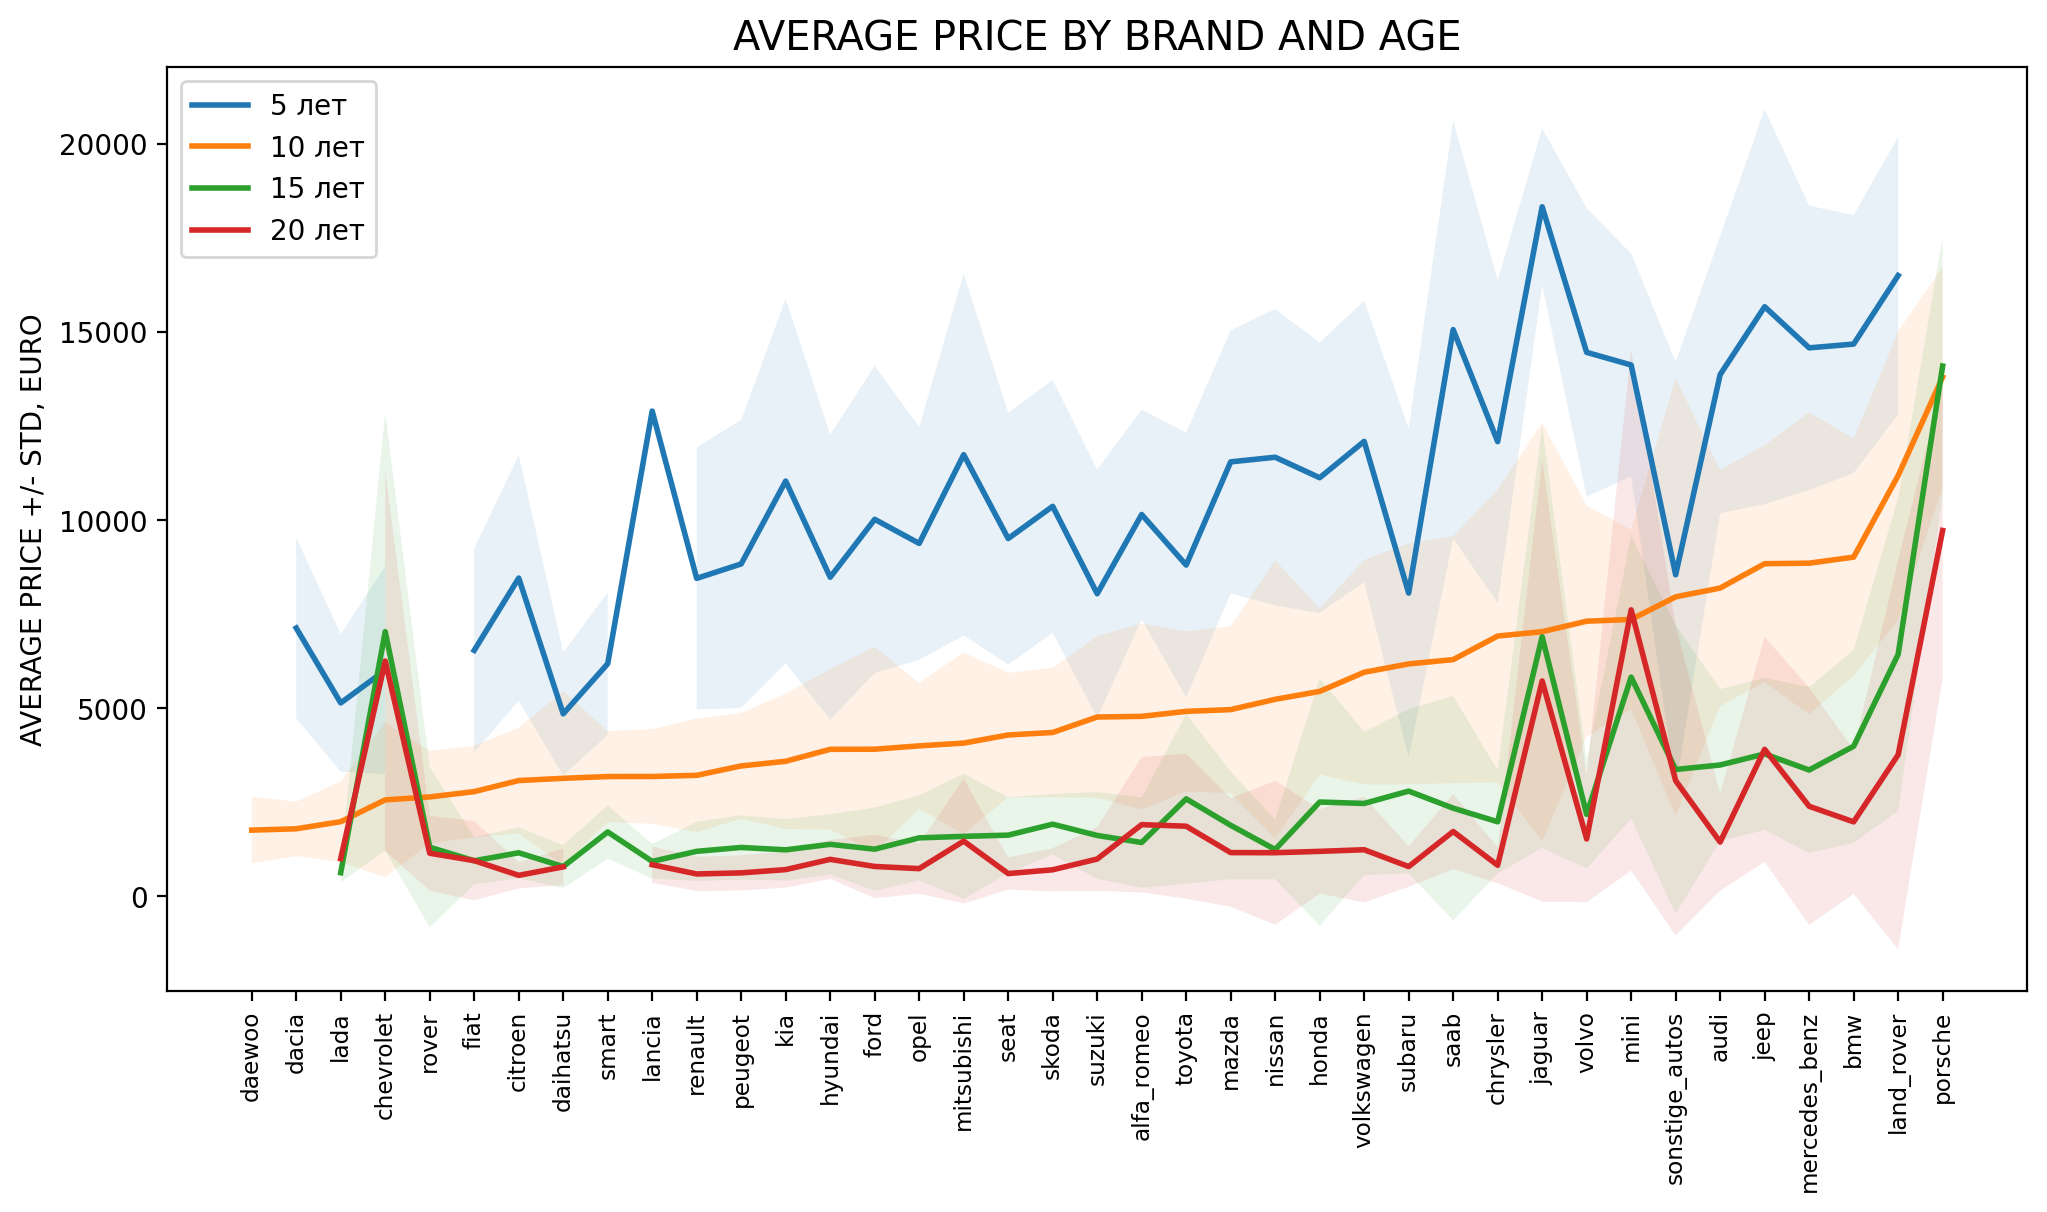

In [64]:
ages = [5, 10, 15, 20]
prices = df.loc[df.CarAge.isin(ages),
                ['CarAge', 'Brand', 'Price']].pivot_table(
                    index='Brand',
                    values='Price',
                    columns='CarAge',
                    aggfunc=['mean', 'std']).sort_values(by=('mean', 10))
fig = plt.figure(figsize=(12, 6))
for age in ages:
    plt.plot(prices.index,
             prices[('mean', age)],
             lw=2,
             label=f"{age} {'год' if age == 1 else 'лет'}")
    plt.fill_between(prices.index,
                     prices[('mean', age)] - prices[('std', age)],
                     prices[('mean', age)] + prices[('std', age)],
                     alpha=.1)
    plt.legend(loc='upper left')
    plt.xticks(rotation=90, fontsize='small')
    plt.title('Average price by brand and age'.upper(),
              fontsize='x-large')
    plt.ylabel('Average price +/- std, Euro'.upper())
plt.show()

We see strong relation between the price and age. The brand impact is not so strong but recognizable as well.

For rare brands, price has a bigger deviations than for popular ones.

#### Conclusions

In EDA we investigated data structure and quality. Conclusions based on the observations are following.

1. Dataset has duplicates, feature with constant valueas `NumberOfPictures` and irrelevant to the task feature `LastSeen`. 
1. Dataset has no unwanted patterns and has errors in records like the `RegistraionDate` in future or engine `Power` that doesn't exists in a car industry.
1. `DateCreated`, `DateCrawled` feautres worth to transform into a single feature `AnketaAge`. Also features `DateCreated`, `RegistrationYear` and `RegistrationMonth` woth to transform into a feature `CarAge`.
1. The largest number of ads in the dataset has a car age from 4 to 20 years inclusive. 
1. Missing values in features may indicate that ads refers to spare parts, and not to the car.

### Data cleaning

At the exploratory data analysis stage we identified the following transformation needed to prepare the dataset for model training and evaluation.

1. Drop duplicates.
1. Drop objects with `Price` missing or less than 300 Euros. 
1. Drop columns `LastSeen` and `NumberOfPictures`.
1. Cast `DateCreated`, `DateCrowled` features to DateTime type and replace them by `AnketaAge` feature $\mathit{AnketaAge} = \mathit{DateCrawled} - \mathit{DateCreated} $. 
1. Replace `RegistrationMonth`, `DateCreated`, `RegistrationYear` with `CarAge` feature. $\mathit{CarAge} = \mathit{round}((\mathit{RegistrationYear} \times 12 + \mathit{RegistrationMonth} - \mathit{year}(\mathit{DateCreated}) \times 12 -  \mathit{month}(\mathit{DateCreated})) \div 12)$.
1. Drop objects with missing values in `Model` or `VehicleType` features.
1. Fill missing values in `Gearbox`, `FuelType` and `NotRepaired`features with `unknown`.
1. Drop objects with `CarAge` less than 4 year or greater than 20 years.
1. Replace `Power` values less than 50 or greater than 250 with `NaN`. Then fill `NaN`s with average engine power for a given car brand and model. Drop objects for which we can not calculate the average power value.
1. Add feature `BrandModel` as concatenation of `Brand` and `Model`.

For these transformations we defined [functions for data cleaining](#data_cleaning_func), and a [class CarPower](#CarPower) with fit and  transform methods.

We don't need the dataset from EDA stage so we delete it.

In [65]:
del(df)

Create lists of steps to clean data.

In [66]:
steps_before = [
    convert_str_to_datetime,
    remove_duplicates,
    drop_na_rows_model_type,
    filter_price,
    add_car_age_feature,
    add_brandmodel_feature,
    add_anketa_age_feature,
    filter_age,
    replace_power_outliers,
]

# here we fix Power values

steps_after = [
    drop_na_rows_power,
    drop_unused_features,
    fill_na_with_unknown
]

Now we clean training dataset.

In [67]:
train_data = X_train.join(y_train)
clean_df = clear_data(train_data.copy(), steps_before)
clean_df.shape

(202124, 19)

Fix Power values.

In [68]:
cars_power = CarPower()
cars_power.fit(clean_df)

In [69]:
clean_df = cars_power.transform(clean_df)

And finish training data cleaning.

In [70]:
clean_df = clear_data(clean_df, steps_after)
clean_df.shape

(202089, 12)

In [71]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202089 entries, 0 to 279201
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   VehicleType  202089 non-null  object 
 1   Gearbox      202089 non-null  object 
 2   Power        202089 non-null  float64
 3   Model        202089 non-null  object 
 4   Kilometer    202089 non-null  int64  
 5   FuelType     202089 non-null  object 
 6   Brand        202089 non-null  object 
 7   NotRepaired  202089 non-null  object 
 8   PostalCode   202089 non-null  int64  
 9   Price        202089 non-null  int64  
 10  CarAge       202089 non-null  int64  
 11  AnketaAge    202089 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 20.0+ MB


Now the data is clean. But what if we were wrong defined the way of data improvement? To answer this question let's
save a dataset where only major issues was fixed. We will compare models on clean data and this dataset later.  

In [72]:
loose_cleaned_data = clear_data(
    train_data.sample(frac=.2, random_state=RANDOM_STATE),
    [convert_str_to_datetime, remove_duplicates, remove_empty_price_rows])

loose_cleaned_data = loose_cleaned_data.fillna('unknown')


del(train_data)

Save feature names we will use in models:
- numerical: `AnketaAge`, `CarAge`, `Power`, `Kilometer`, `PostalCode`
- categorical: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`

In [73]:
numerical_features = ['AnketaAge', 'CarAge', 'Power', 'Kilometer', 'PostalCode']
categorical_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired']

In [74]:
clean_df[numerical_features].describe()

,AnketaAge,CarAge,Power,Kilometer,PostalCode
count,202089.000000,202089.000000,202089.000000,202089.000000,202089.000000
mean,0.850863,12.261538,120.554054,130891.909010,51204.977159
std,1.689966,4.341254,45.575007,33216.527791,25560.211262
min,0.000000,4.000000,50.000000,5000.000000,1067.000000
25%,1.000000,9.000000,82.000000,125000.000000,31020.000000
50%,1.000000,12.000000,116.000000,150000.000000,50321.000000
75%,1.000000,16.000000,150.000000,150000.000000,71577.000000
max,370.000000,20.000000,250.000000,150000.000000,99998.000000


In [75]:
clean_df[categorical_features].describe()

,VehicleType,Gearbox,Brand,Model,FuelType,NotRepaired
count,202089,202089,202089,202089,202089,202089
unique,8,3,38,243,8,3
top,sedan,manual,volkswagen,golf,petrol,no
freq,57406,155584,41564,15412,124122,155892


Finally let's build training features and target.

In [76]:
X_train = clean_df[categorical_features+numerical_features]
y_train = clean_df.Price

In [77]:
del(clean_df)

Repeat the steps above to the test dataset.

In [78]:
X_train.shape, y_train.shape

((202089, 11), (202089,))

In [79]:
clean_test_df = clear_data(X_test.join(y_test), steps_before)
clean_test_df.shape

(51251, 19)

In [80]:
clean_test_df = cars_power.transform(clean_test_df)

In [81]:
clean_test_df = clear_data(clean_test_df, steps_after)
clean_test_df.shape

(51242, 12)

In [82]:
X_test = clean_test_df[categorical_features+numerical_features]
y_test = clean_test_df.Price

In [83]:
X_test.shape, y_test.shape

((51242, 11), (51242,))

In [84]:
del(clean_test_df)

### Conclusions

We explored the structure and quality of the data. We found issues in data and fixed them. 

As the goal of this work is prediction a price of a car we defied the scope of the model:
- car age from 4 to 20 years inclusive,
- vehical type and car model are required,
- vehicle power is in 50–250 hp range inclusive,
- the minimum car price is 300 euros.

## Models Training

To keep training time short we take 20% sample of training data and explore different approaches and hyperparameters tuning. Then we train the best perfoming model on the full training dataset.

In [85]:
sample = X_train.join(y_train).sample(frac=.2, random_state=RANDOM_STATE)
X_sample = sample.drop('Price', axis=1)
y_sample = sample.Price
del(sample)
X_sample.shape, y_sample.shape

((40418, 11), (40418,))

We apply RepeatedKFold cross-validation to evaluate results.

In [86]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

Let's measure the baseline RMSE values for linear regression and a Dummy model that returns the average value of the target feature as a forecast.

In [87]:
column_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [88]:
pipeline_lr = make_pipeline(column_transformer, LinearRegression(n_jobs=-1))
pipeline_dm = make_pipeline(column_transformer, DummyRegressor())

In [89]:
%%time
for est, name in zip([pipeline_lr, pipeline_dm], ['Linear Regression', 'Dummy Regression']): 
    print(name)
    cross_validate_model(est, X_sample, y_sample)

Linear Regression
fit time	 1.08s +/- 0.13s
score time	 0.05s +/- 0.02s
RMSE		 2111 +/- -33
R2 		 0.770 +/- 0.005

Dummy Regression
fit time	 0.17s +/- 0.02s
score time	 0.05s +/- 0.01s
RMSE		 4399 +/- -47
R2 		 -0.000 +/- 0.000

CPU times: user 573 ms, sys: 173 ms, total: 746 ms
Wall time: 7.47 s


The RMSE of the linear regression is almost twice as good as the random model. So our model is valid. Note this linear regression model already has RMSE less than 2500 that is required by the customer. Let's see if we can do it better.

### Data cleaning test

To make sure we cleaned the data correctly, let's compare the RMSE for the cleaned data and for the data where only the major issues have been fixed.

In [90]:
loose_cleaned_data_columns_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(dtype='int', handle_unknown='ignore'),
      ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired']),
     ('numerical', StandardScaler(), [
         'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
         'PostalCode'
     ])],
    remainder='drop')
loose_cleaned_data_pipeline = make_pipeline(
    loose_cleaned_data_columns_transformer, LinearRegression(n_jobs=-1))

In [91]:
print('Cleaned dataset')
cross_validate_model(pipeline_lr, X_sample, y_sample)

print('Dataset without cleaning')
cross_validate_model(loose_cleaned_data_pipeline,
                     loose_cleaned_data.drop('Price', axis=1),
                     loose_cleaned_data.Price)

print()

Cleaned dataset
fit time	 1.12s +/- 0.09s
score time	 0.06s +/- 0.01s
RMSE		 2111 +/- -28
R2 		 0.770 +/- 0.005

Dataset without cleaning
fit time	 1.23s +/- 0.08s
score time	 0.06s +/- 0.01s
RMSE		 3132 +/- -24
R2 		 0.522 +/- 0.006




The result on cleaned data is much better. We are now sure that the data was pre-processed correctly.

### Features selection

Which of the features we have are important for prediction, and which are not? To answer, we sequentially remove one feature from the data and evaluate the quality of the model on the remaining features.

In [92]:
removed_columns, scores = [], []

for column in numerical_features:
    reduced_numerical_features = numerical_features.copy()
    reduced_numerical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, reduced_numerical_features,
                      categorical_features, cv))

    print(column, reduced_numerical_features, f'{scores[-1]:.3f}')

    
for column in categorical_features:
    reduced_categorical_features = categorical_features.copy()
    reduced_categorical_features.remove(column)

    removed_columns.append(column)
    scores.append(
        get_cv_result(X_sample, y_sample, numerical_features,
                      reduced_categorical_features, cv))
    
    print(column, reduced_categorical_features, f'{scores[-1]:.3f}')

    
features_impact = pd.DataFrame({'removed_column': removed_columns, 'rmse': scores})    

AnketaAge ['CarAge', 'Power', 'Kilometer', 'PostalCode'] 0.770
CarAge ['AnketaAge', 'Power', 'Kilometer', 'PostalCode'] 0.606
Power ['AnketaAge', 'CarAge', 'Kilometer', 'PostalCode'] 0.752
Kilometer ['AnketaAge', 'CarAge', 'Power', 'PostalCode'] 0.753
PostalCode ['AnketaAge', 'CarAge', 'Power', 'Kilometer'] 0.769
VehicleType ['Gearbox', 'Brand', 'Model', 'FuelType', 'NotRepaired'] 0.764
Gearbox ['VehicleType', 'Brand', 'Model', 'FuelType', 'NotRepaired'] 0.767
Brand ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'] 0.764
Model ['VehicleType', 'Gearbox', 'Brand', 'FuelType', 'NotRepaired'] 0.740
FuelType ['VehicleType', 'Gearbox', 'Brand', 'Model', 'NotRepaired'] 0.770
NotRepaired ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType'] 0.763


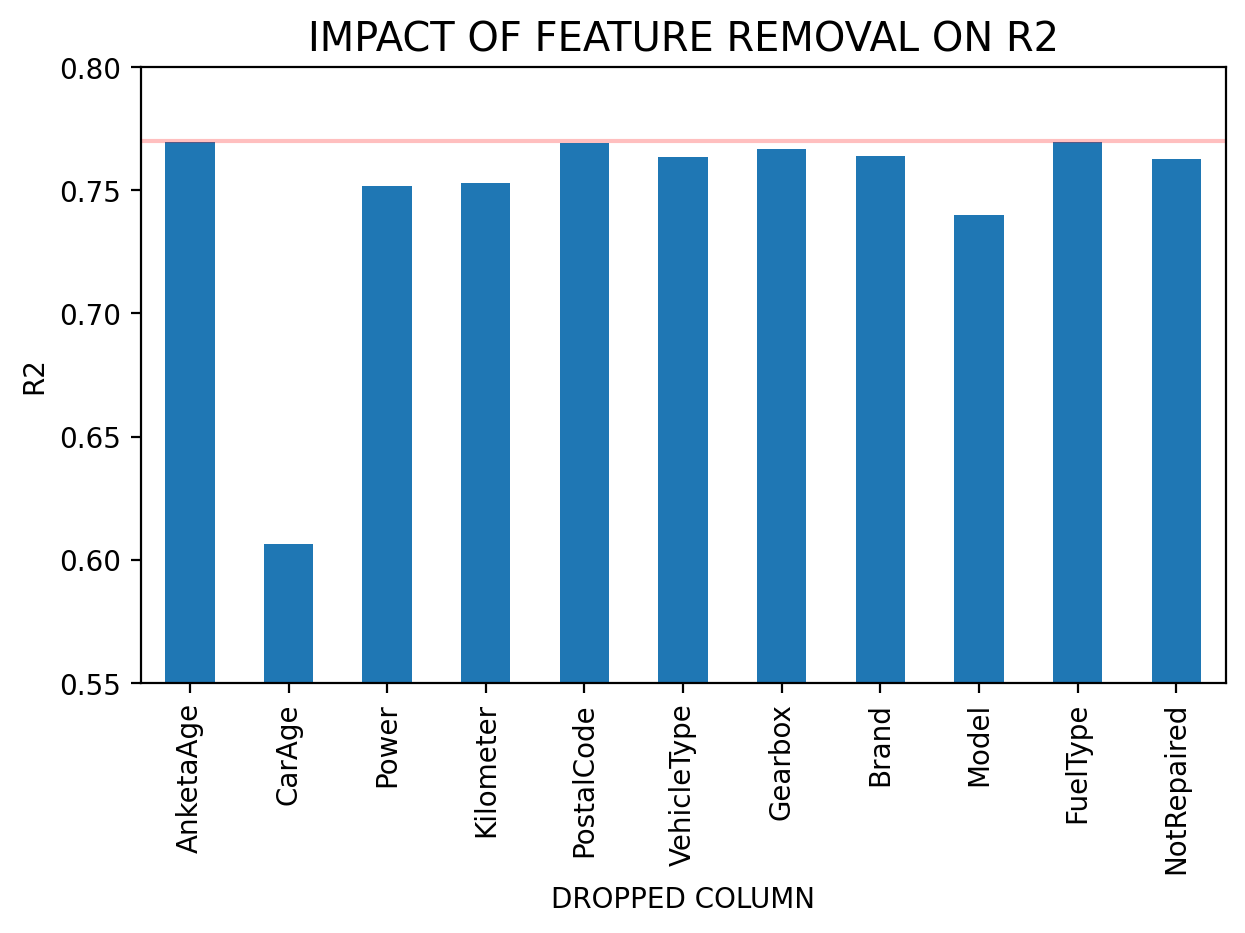

In [93]:
ax = features_impact.plot.bar(xticks=features_impact.index,
                              rot=90,
                              figsize=(7, 4),
                              legend=None)
ax.set_xticklabels(features_impact.removed_column)
plt.axhline(.77, c='r', alpha=.25)
plt.title('Impact of Feature Removal on R2'.upper(), fontsize='x-large')
plt.xlabel('Dropped column'.upper())
plt.ylabel('R2'.upper())
plt.ylim(.55, .8)
plt.show()

Dropping any of `AnketaAge`, `PostalCode`, `FuelType` feature doesn't affect R2. So these features are non important abnd we remove them from further usage.

The most impotant feature is `CarAge`.

In [94]:
numerical_features.remove('AnketaAge')
numerical_features.remove('PostalCode')

numerical_features

['CarAge', 'Power', 'Kilometer']

In [95]:
categorical_features.remove('FuelType')

categorical_features

['VehicleType', 'Gearbox', 'Brand', 'Model', 'NotRepaired']

### Algorithms evaluation

We have a regression problem to be solved in supervised learning way. Let's evaluate the following algotithms:

- LinearRegression as a quick solution,
- DecisionTreeRegressor as a quick non-linear solution,
- HistGradientBoostingRegressor as an efficient gradient boosting algorythm from scikit-learn,
- LGBMRegressor as an efficient gradient boosting algorythm from Microsoft

HistGradientBoostingRegressor and LGBMRegressor have support of categorical features. Let's compare model quality  using OHE encoding for categorical features, and built-in processing of categorical features in these algorythms.

In [96]:
ohe_sparse_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(
        dtype='int', handle_unknown='ignore'), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [97]:
ohe_dense_transformer = ColumnTransformer(
    [('categorical',
      OneHotEncoder(dtype='int', handle_unknown='ignore',
                    sparse=False), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [98]:
ordinal_transformer = ColumnTransformer(
    [('categorical',
      OrdinalEncoder(handle_unknown="use_encoded_value",
                     unknown_value=np.nan), categorical_features),
     ('numerical', StandardScaler(), numerical_features)],
    remainder='drop')

In [99]:
categorical_mask = [True] * len(categorical_features) + [False] * len(
    numerical_features)
fit_params = {
    'lgbmregressor__categorical_feature':
    [_ for _ in range(len(categorical_features))]
}

In [100]:
baseline_estimators = [
    make_pipeline(ohe_sparse_transformer, LinearRegression(n_jobs=-1)),
    make_pipeline(
        ohe_sparse_transformer,
        DecisionTreeRegressor(min_samples_leaf=100, random_state=RANDOM_STATE)),
    make_pipeline(
        ohe_dense_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      random_state=RANDOM_STATE)),
    make_pipeline(
        ordinal_transformer,
        HistGradientBoostingRegressor(min_samples_leaf=31,
                                      categorical_features=categorical_mask,
                                      random_state=RANDOM_STATE)),
    make_pipeline(ohe_sparse_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
    make_pipeline(ordinal_transformer,
                  LGBMRegressor(random_state=RANDOM_STATE)),
]

In [101]:
scores = dict()
for est, name in zip(baseline_estimators, [
        'LinearRegression', 'DecisionTree',
        'HistGradientBoosting OHE',
        'HistGradientBoosting & categorical', 'LGBM OHE',
        'LGBM & categorical'
]):
    print(name)
    params = fit_params if name == 'LGBM & categorical' else dict()
    scores[name] = cross_validate_model(est,
                                        X_sample,
                                        y_sample,
                                        fit_params=params)

LinearRegression
fit time	 0.73s +/- 0.07s
score time	 0.04s +/- 0.00s
RMSE		 2115 +/- -19
R2 		 0.769 +/- 0.005

DecisionTree
fit time	 0.65s +/- 0.01s
score time	 0.05s +/- 0.01s
RMSE		 2091 +/- -28
R2 		 0.774 +/- 0.005

HistGradientBoosting OHE
fit time	 16.13s +/- 3.62s
score time	 0.50s +/- 0.08s
RMSE		 1634 +/- -19
R2 		 0.862 +/- 0.004

HistGradientBoosting & categorical
fit time	 1.68s +/- 0.11s
score time	 0.25s +/- 0.01s
RMSE		 1564 +/- -23
R2 		 0.874 +/- 0.004

LGBM OHE
fit time	 0.62s +/- 0.03s
score time	 0.18s +/- 0.01s
RMSE		 1621 +/- -39
R2 		 0.864 +/- 0.007

LGBM & categorical


/Volumes/T7/working/portfolio/car-price-prediction-demo/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/portfolio/car-price-prediction-demo/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/portfolio/car-price-prediction-demo/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/portfolio/car-price-prediction-demo/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Volumes/T7/working/portfolio/car-price-prediction-demo/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning:

fit time	 0.57s +/- 0.03s
score time	 0.15s +/- 0.01s
RMSE		 1562 +/- -35
R2 		 0.874 +/- 0.005



Using LGBM with the Scikit-learn API results in warnings about using categorical features from the dataset when specifying indexes in the `categorical_feature` parameter. To avoid warnings in the future, we will prepare the features in a pandas DataFrame with type categorical.

Let's make a visual analysis of the results.

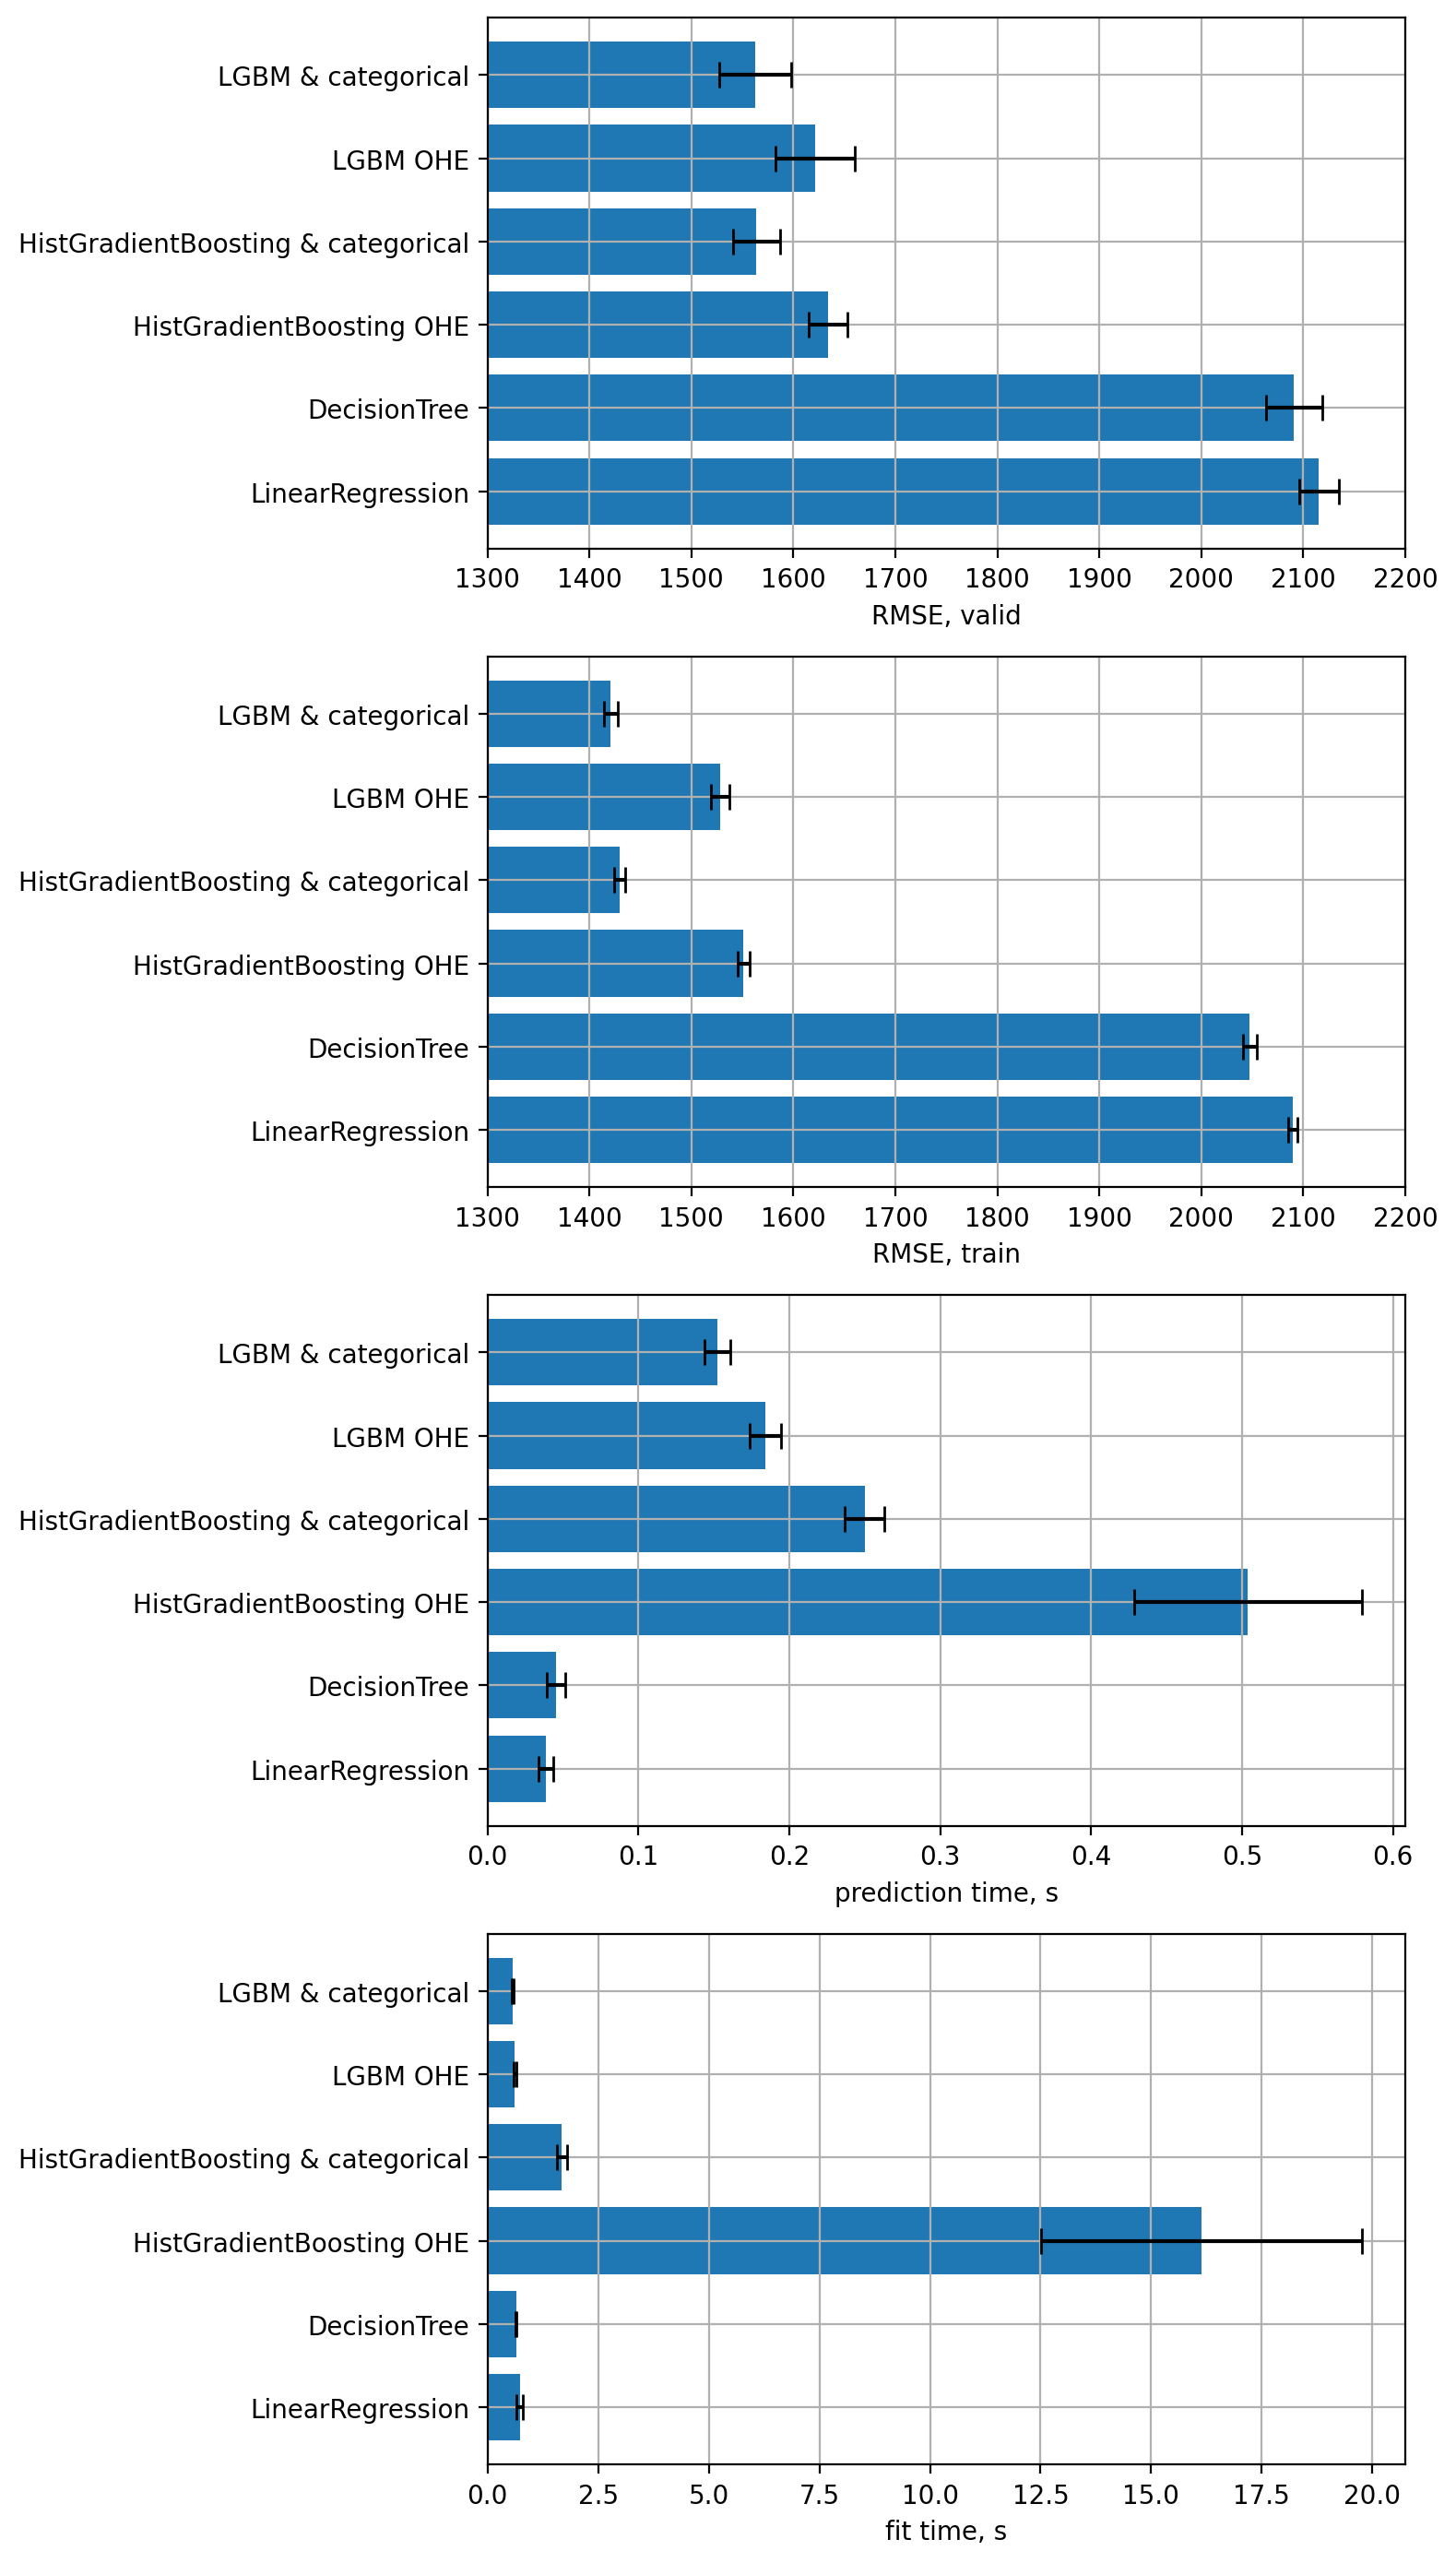

In [102]:
fig, axes = plt.subplots(4, 1, figsize=(8, 14))

labels = list(scores.keys())
y_pos = range(len(labels))

test_rmse = get_scoring_values(scores, "test_neg_root_mean_squared_error")
plot_comaprison_bar(axes[0], -1 * test_rmse.mean(axis=1),
                    test_rmse.std(axis=1), labels, "RMSE, valid", xlim=(1300,2200))

train_rmse = get_scoring_values(scores, "train_neg_root_mean_squared_error")
plot_comaprison_bar(axes[1], -1 * train_rmse.mean(axis=1),
                    train_rmse.std(axis=1), labels, "RMSE, train", xlim=(1300,2200))

score_time = get_scoring_values(scores, "score_time")
plot_comaprison_bar(axes[2], score_time.mean(axis=1), score_time.std(axis=1),
                    labels, "prediction time, s")

fit_time = get_scoring_values(scores, "fit_time")
plot_comaprison_bar(axes[3], fit_time.mean(axis=1), fit_time.std(axis=1),
                    labels, "fit time, s")

plt.tight_layout()
plt.show()

We got RMSE less than 1600 both for HistGradientBoosting and LGBM models with built-in processing of categorical features. LinearRegression has the worst result.

DecisionTree model has the shortest prediction time. Among the models with the best prediction quality, LGBM prediction is 3 times faster than that of HistGradientBoosting.

DecisionTree and LGBM are the fastest in training. 

Let's exclude Linear regression as a model with worst quality and mediocre train and prediction time. 

For the remaining models we will tune hyperparameters and compare the results once again.

### Hyperparameters tuning

Prepare data with encoded categorical features and scaled numerical features.

In [103]:
X_sample = pd.DataFrame(ordinal_transformer.fit_transform(X_sample),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_sample[column] = pd.Categorical(X_sample[column])
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40418 entries, 0 to 40417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   VehicleType  40418 non-null  category
 1   Gearbox      40418 non-null  category
 2   Brand        40418 non-null  category
 3   Model        40418 non-null  category
 4   NotRepaired  40418 non-null  category
 5   CarAge       40418 non-null  float64 
 6   Power        40418 non-null  float64 
 7   Kilometer    40418 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 1.2 MB


In [104]:
X_sample.head()

,VehicleType,Gearbox,Brand,Model,NotRepaired,CarAge,Power,Kilometer
0,2.0,1.0,20.0,55.0,0.0,0.409064,0.185851,0.577559
1,4.0,1.0,30.0,134.0,2.0,-1.430911,-0.340202,0.577559
2,5.0,1.0,9.0,170.0,1.0,0.869058,-1.326552,-0.174549
3,4.0,1.0,19.0,15.0,0.0,1.099055,-0.099094,0.577559
4,2.0,1.0,20.0,72.0,1.0,1.099055,0.339283,0.577559


#### DecisionTreeRegressor

In [105]:
dt_param_distributions = {
    'max_depth': np.arange(100, 600, 100),
    'min_samples_split': [2**i for i in range(4, 11)],
    'min_samples_leaf': [2**i for i in range(3, 9)]
}

In [106]:
dt_search_estimator = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_distributions=dt_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [107]:
%%time
try:
    dt_search_results = load_object('data/dt_search_results.pkl')  
except:
    dt_search_results = dt_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/dt_search_results.pkl', dt_search_results)    

CPU times: user 2.5 ms, sys: 1.92 ms, total: 4.42 ms
Wall time: 5.22 ms


#### LGBMRegressor

In [108]:
lgbm_param_distributions = {
    'n_estimators': np.arange(200, 1600, 100),
    'num_leaves': [2**i for i in range(3, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'subsample': [0.3, 0.5, 0.7, 0.9, 1],
    'subsample_freq': [5, 25, 625],
    'min_child_samples': np.arange(25, 275, 25),
    'reg_lambda': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0)),
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]
}

In [109]:
lgbm_search_estimator = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=RANDOM_STATE),
    param_distributions=lgbm_param_distributions,
    n_iter=200,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

In [110]:
%%time
try:
    lgbm_search_results = load_object('data/lgbm_search_results.pkl')
except:
    lgbm_search_results = lgbm_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/lgbm_search_results.pkl', lgbm_search_results)    

CPU times: user 3.04 ms, sys: 2 ms, total: 5.04 ms
Wall time: 4.69 ms


#### HistGradientBoostingRegressor

In [111]:
hgbr_param_distributions = {
    'max_iter': np.arange(100, 1600, 100),
    'max_leaf_nodes': [2**i for i in range(1, 9)],
    'learning_rate': np.logspace(-2, 1, num=20, endpoint=True, base=10, dtype=float, axis=0),
    'min_samples_leaf': np.arange(25, 275, 25),
    'l2_regularization': np.append([0],
                    np.logspace(0,
                                3,
                                num=20,
                                endpoint=True,
                                base=10,
                                dtype=float,
                                axis=0))
}

In [112]:
hgbr_search_estimator = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(
        categorical_features=categorical_mask, random_state=RANDOM_STATE),
    param_distributions=hgbr_param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=False,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True)

In [113]:
%%time
try:
    hgbr_search_results = load_object('data/hgbr_search_results.pkl')  
except:
    hgbr_search_results = hgbr_search_estimator.fit(X_sample, y_sample)
    if path.isdir('data'):
        save_object('data/hgbr_search_results.pkl', hgbr_search_results)    

CPU times: user 2.7 ms, sys: 1.92 ms, total: 4.62 ms
Wall time: 3.7 ms


### Model Analysis

We need following metrics of hyperparameter tuning stage for analysis.

In [114]:
results_columns = [
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score',
    'params', 'rank_test_score'
]

For models with default hyperparameter values, we got RMSEs below 1600. Therefore, we filter out experiments with RMSE values above 1600. We also filter out experiments with low RMSEs on the train because they are overfitted.

In [115]:
dt_results = pd.DataFrame(
    dt_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1950').sort_values(by="mean_test_score")


lgbm_results = pd.DataFrame(
    lgbm_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1400').sort_values(by="mean_test_score")


hgbr_results = pd.DataFrame(
    hgbr_search_results.cv_results_)[results_columns].query(
        'mean_test_score > -1600 and mean_train_score < -1400').sort_values(by="mean_test_score")

Let's plot RMSE, fit and predict time of experiments for each model sorted by descending RMSE on validation data.

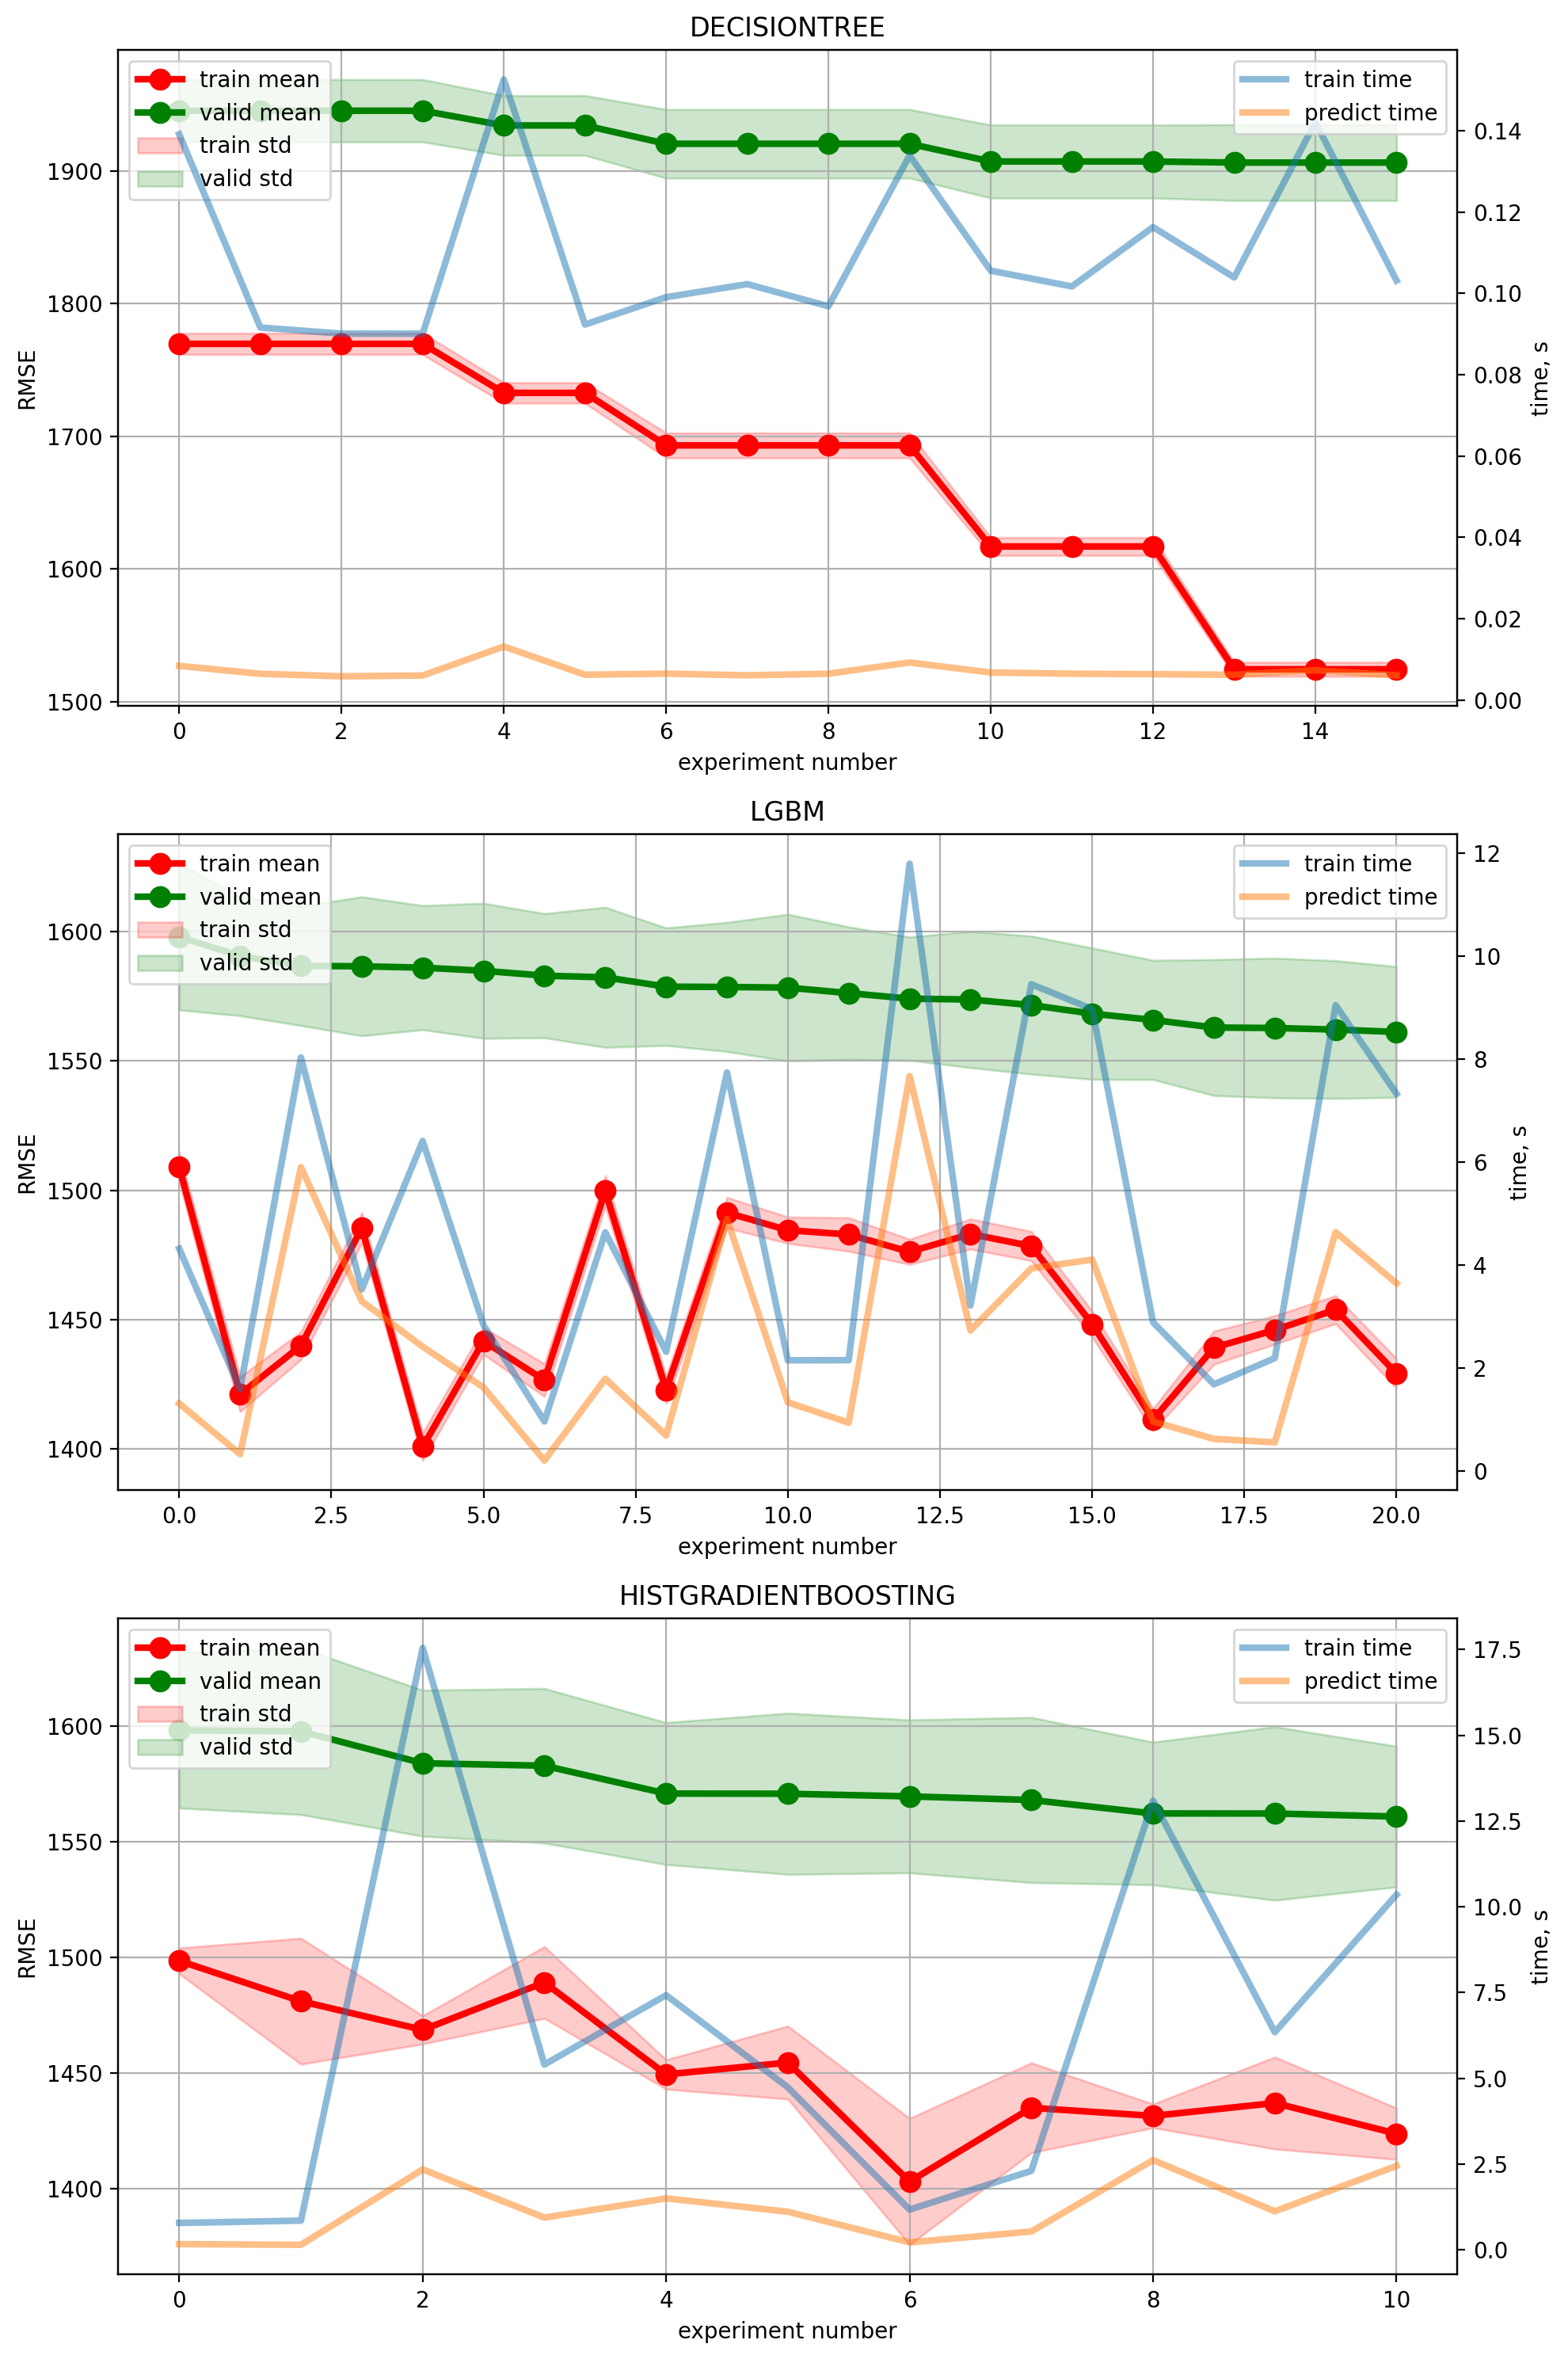

In [116]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plot_searh_curve(dt_results, ax=axes[0], model_name='DecisionTree')
plot_searh_curve(lgbm_results, ax=axes[1], model_name='LGBM')
plot_searh_curve(hgbr_results, ax=axes[2], model_name='HistGradientBoosting')
plt.tight_layout()
plt.show()

The righmost experiments on the chart have the lowest RMSE. 

Let's choose as the winners the experiments on the right, which have less RMSE when trained, thus we reduce overfitting. We also take into account the training time.

For DecisionTree, we select the fifth experiment on the right, for LGBM - the first experiment on the right, for HistGradientBoosting - the third experiment on the right.

In [117]:
dt_best_idx = -5
lgbm_best_idx = -1
hgbr_best_idx = -3

Display experiment results in a table.

In [118]:
_cols = hgbr_results.columns.to_list()
_cols.remove('params')
_cols.remove('rank_test_score')

dt_best_params = dt_results.iloc[[dt_best_idx]].params.values[0]
lgbm_best_params = lgbm_results.iloc[[lgbm_best_idx]].params.values[0]
hgbr_best_params = hgbr_results.iloc[[hgbr_best_idx]].params.values[0]

comparison = pd.concat([
    dt_results.iloc[[dt_best_idx]], lgbm_results.iloc[[lgbm_best_idx]],
    hgbr_results.iloc[[hgbr_best_idx]]
])[_cols].T
comparison.columns = ['DecisionTree', 'LGBM', 'HistGradientBoosting']

comparison

,DecisionTree,LGBM,HistGradientBoosting
mean_fit_time,0.101699,7.333516,13.092121
std_fit_time,0.002542,0.721373,0.350145
mean_score_time,0.006487,3.650163,2.617821
std_score_time,0.000690,1.217671,0.085003
mean_test_score,-1907.271528,-1561.232209,-1562.339134
std_test_score,27.577222,25.300519,30.889117
mean_train_score,-1616.883795,-1429.128307,-1431.435888
std_train_score,6.811582,5.770529,5.124604


Finally let's make a visual analysis of the results.

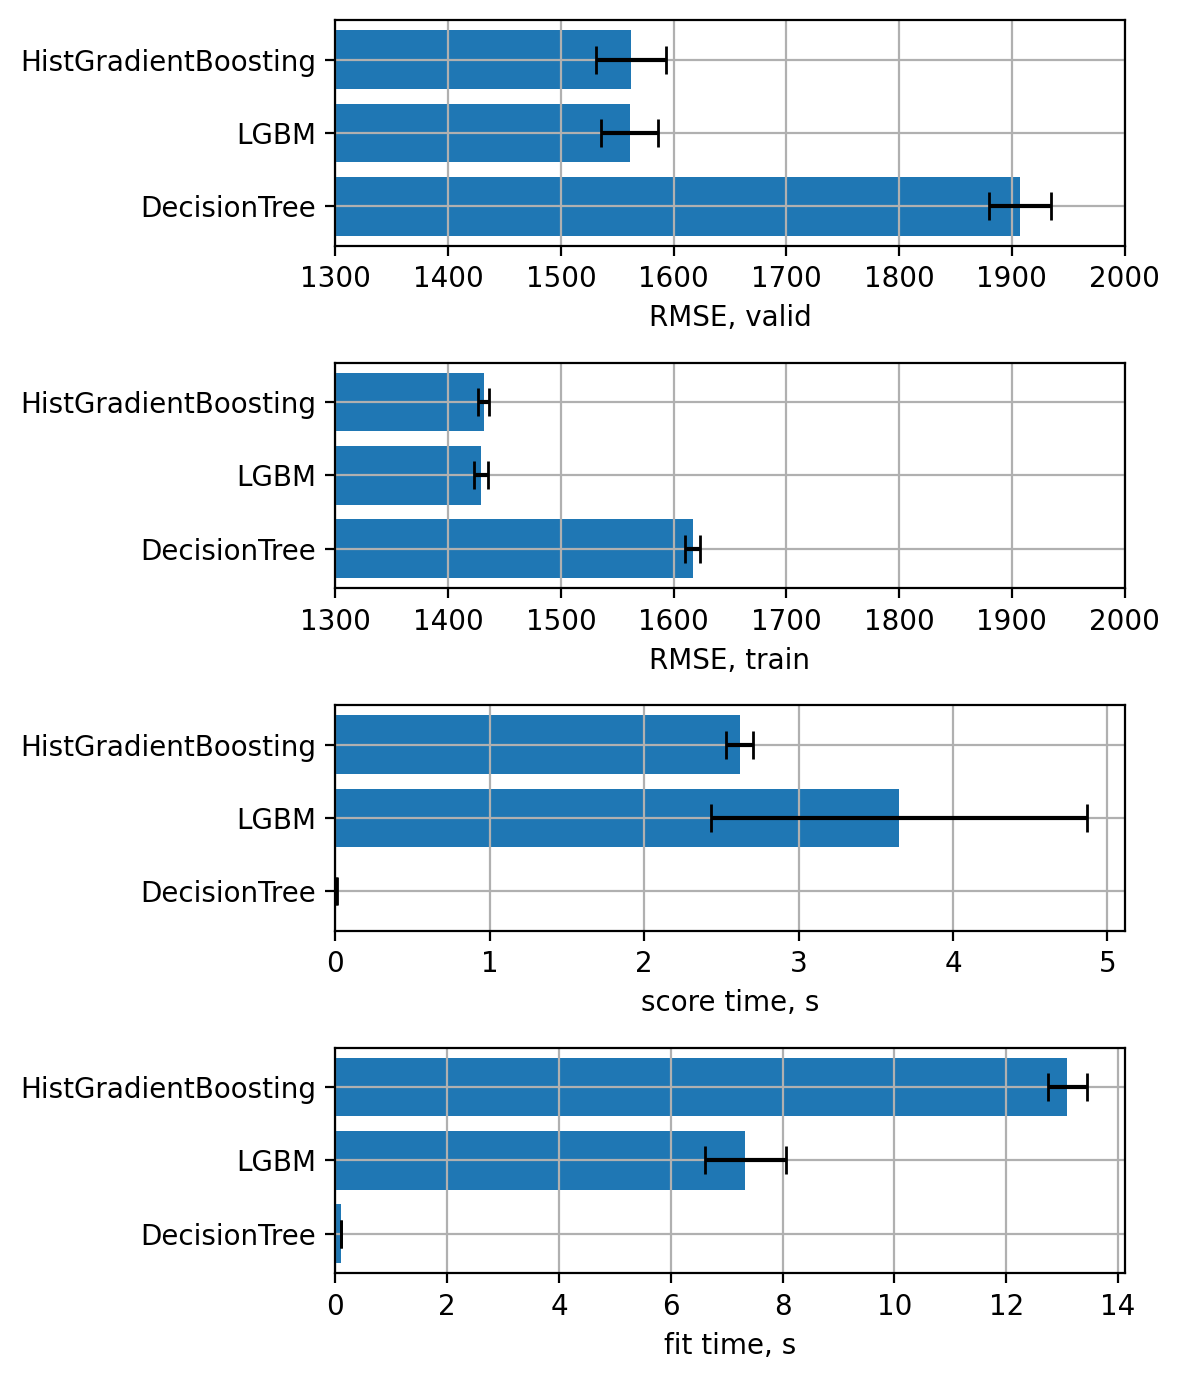

In [119]:
fig, axes = plt.subplots(4, 1, figsize=(6, 7))

labels = comparison.columns.to_list()
y_pos = range(len(labels))

plot_comaprison_bar(axes[0], -1 * comparison.loc["mean_test_score"].values,
                    comparison.loc["std_test_score"].values, labels,
                    "RMSE, valid", xlim=(1300,2000))

plot_comaprison_bar(axes[1], -1 * comparison.loc["mean_train_score"].values,
                    comparison.loc["std_train_score"].values, labels,
                    "RMSE, train", xlim=(1300,2000))

plot_comaprison_bar(axes[2], comparison.loc["mean_score_time"].values,
                    comparison.loc["std_score_time"].values, labels,
                    "score time, s")

plot_comaprison_bar(axes[3], comparison.loc["mean_fit_time"].values,
                    comparison.loc["std_fit_time"].values, labels,
                    "fit time, s")

plt.tight_layout()
plt.show()

The hyperparameters funituning made it possible to slightly reduce the validation RMSE and increase the RMSE on the training set, that is, to reduce the effect of model overfitting.

DecisionTree is still the fastest of the considered solutions, but it is much inferior in terms of prediction quality. Nevertheless, the results of the DecisionTree satisfy the requirements - RMSE is less than 2500. If time is a critical indicator, this model should be chosen.

HistGradientBoosting and LGBM give the same prediction quality, while LGBM has a longer inference time and is faster to learn.

We will choose these two models as finalists. If we need less prediction time, we can use HistGradientBoosting. If less training time - LGBM.

### Full data training

With the best algorithms and hyperparameters selected, let's train the models on the full training dataset.

These are the best hyperparameters.

In [120]:
(dt_best_params, lgbm_best_params, hgbr_best_params)

({'min_samples_split': 32, 'min_samples_leaf': 8, 'max_depth': 500},
 {'subsample_freq': 5,
  'subsample': 0.3,
  'reg_lambda': 162.3776739188721,
  'num_leaves': 256,
  'n_estimators': 900,
  'min_child_samples': 50,
  'learning_rate': 0.04281332398719394,
  'colsample_bytree': 1},
 {'min_samples_leaf': 150,
  'max_leaf_nodes': 32,
  'max_iter': 1100,
  'learning_rate': 0.01438449888287663,
  'l2_regularization': 54.55594781168517})

We need to transform training and test datasets: make ategorical features encoding and scaling of numerical ones. For the transformation, we use the saved `ColumnTransformer`.

In [121]:
ordinal_transformer.fit(X_train)

X_train = pd.DataFrame(ordinal_transformer.transform(X_train),
                        columns=categorical_features + numerical_features)
X_test = pd.DataFrame(ordinal_transformer.transform(X_test),
                        columns=categorical_features + numerical_features)

for column in categorical_features:
    X_train[column] = pd.Categorical(X_train[column])
    X_test[column] = pd.Categorical(X_test[column])

In [122]:
X_train.shape, y_train.shape

((202089, 8), (202089,))

In [123]:
X_test.shape, y_test.shape

((51242, 8), (51242,))

We are ready to train models.

In [124]:
lgbm_model = LGBMRegressor(**lgbm_best_params, random_state=RANDOM_STATE)

lgbm_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.04281332398719394,
              min_child_samples=50, n_estimators=900, num_leaves=256,
              random_state=RandomState(MT19937) at 0x130C2D340,
              reg_lambda=162.3776739188721, subsample=0.3, subsample_freq=5)

In [125]:
hgbr_model = HistGradientBoostingRegressor(**hgbr_best_params,
        categorical_features=categorical_mask, random_state=RANDOM_STATE)

hgbr_model.fit(X_train, y_train)

HistGradientBoostingRegressor(categorical_features=[True, True, True, True,
                                                    True, False, False, False],
                              l2_regularization=54.55594781168517,
                              learning_rate=0.01438449888287663, max_iter=1100,
                              max_leaf_nodes=32, min_samples_leaf=150,
                              random_state=RandomState(MT19937) at 0x130C2D340)

### Conclusions

During the model training phase, we performed the following
- measured baseline performance predicting the mean outcome value that is of 4399. Every model developed has a better performance,
- made sure that the chosen cleaning and data preparation methods had a positive effect on the quality of the model,
- analyzed feature importance and chose only significant features,
- analyzed the prediction quality, training and inference time for four algorithms: linear regression, decision tree, LGBM, and HistGradientBoosting,
- For the decision tree, LGBM and HistGradientBoosting, we fine tuned hyper-parameters that provide quality needed and protection against model overfitting.

As a result, we have obtained two models with comparable prediction quality based on the LGBM and HistGradientBoosting algorithms. The goal of getting a model with an RMSE less than 2500 has been achieved. Our validation set models have an RMSE of 1561 +/- 25.

## Test models

Finally, we evaluate the trained models on the test dataset.

In [126]:
lgbm_test_predictions = lgbm_model.predict(X_test)

hgbr_test_predictions = hgbr_model.predict(X_test)

In [127]:
lgbm_test_rmse = mean_squared_error(y_test, lgbm_test_predictions, squared=False)
print(f"LGBM RMSE (test): {lgbm_test_rmse}")

LGBM RMSE (test): 1430.7586495644614


In [128]:
hgbr_test_rmse = mean_squared_error(y_test, hgbr_test_predictions, squared=False)
print(f"HistGradientBoosting RMSE (test): {hgbr_test_rmse}")

HistGradientBoosting RMSE (test): 1481.9246196460826


An increase in the size of the training sample had a positive effect on the model quality. We obtained close RMSE values on the training and test sets. The chosen hyperparameters keep the models from ovefitting. 

## Conclusions

We have developed car price prediction models and ensured a given level of prediction quality. The resulting models demonstrated RMSE on a test set of about 1450 with the required RMSE of no more than 2500.

To achieve this goal, we analyzed the data and defined the scope of the model:
- car age from 4 to 20 years inclusive,
- it is necessary to have information about the type of car body and model,
- vehicle power from 50 to 250 hp inclusive,
- the minimum car price is 300 euros.

We compared 4 models in terms of prediction quality, training time, and inference time and chose two comparable in quality, differing in training and prediction time. The choice between final models can be made based on the priorities of training and inference time.